In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import gridspec
import lasio
from welly import Project

%matplotlib inline

# Define a default font for the figures
matplotlib.rcParams['font.sans-serif'] = "Arial"
matplotlib.rcParams['font.family'] = "sans-serif"
matplotlib.rcParams['font.size'] = 14
plt.rc('xtick',labelsize=14)
plt.rc('ytick',labelsize=14)

# Initialize Plotly and Cufflinks
from plotly import __version__
import cufflinks as cf
from plotly.offline import download_plotlyjs,init_notebook_mode,plot,iplot
init_notebook_mode(connected=True)
cf.go_offline()

In [18]:
p = Project.from_las('*.las')

0it [00:00, ?it/s]Header section Parameter regexp=~P was not found.
1it [00:00,  3.59it/s]Header section Parameter regexp=~P was not found.
3it [00:02,  1.49it/s]


In [19]:
alias={
    'Phi':['PHIE','PHIT'],
    'Vsh':['VSHALE','VSH'],
    'Sw':['SW_CRETSYS','SWT'],
    'rho':['RHOB','ZDEN','DENS'],
    'DT':['DTC','DT'],
    'DTS':['DTS','DTDS']
}

keys=[]
for k in alias.keys():
    keys.append(k)

html1 = p.curve_table_html()
html = p.curve_table_html(keys=keys,alias=alias)

In [20]:
from IPython.display import HTML
HTML(html)

In [21]:
import welly.quality as qty
tests = {
    'All': [qty.no_similarities],
    'Phi': [
        qty.all_positive,
        qty.mean_between(0,0.8),
    ],
    'Vsh': [
        qty.all_positive,
        qty.mean_between(0, 1),
    ],
    'Sw': [
        qty.all_positive,
        qty.mean_between(0, 1),
    ],
    'rho': [qty.mean_between(1,3)],
    'DT': [qty.mean_between(120, 500)],
    }

html = p.curve_table_html(keys=keys, alias=alias, tests=tests)
HTML(html)

THE GREEN DOT MEANS THAT ALL TESTS PASSED FOR THAT CURVE. ORANGE MEANS SOME TESTS FAILED. IF ALL TESTS FAIL, THE DOT IS RED. THE QUALITY SCORE SHOWS A NORMALIZED SCORE FOR ALL THE TESTS ON THAT WELL.

In [22]:
p_sub= Project.from_las("*.las",alias=alias,req=keys)

0it [00:00, ?it/s]Header section Parameter regexp=~P was not found.
1it [00:00,  3.90it/s]Header section Parameter regexp=~P was not found.
3it [00:01,  1.57it/s]


In [23]:
dfs=[]

for w in p_sub:
    try:
        dfs.append(w.df())
        dfs[-1]['UWI']=w.uwi
        dfs[-1]['MD']=w.survey_basis()
    except:
        print("{}".format(w.uwi))
    

df=pd.concat(dfs,ignore_index=True)
df.loc[df.UWI == '','UWI'] = 'Jude-1'

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




## Load well data

In [24]:

# BO-2X
bo2 = lasio.read('BO-2X.las').df()
bo2 = bo2[['DT','DTDS','PHIE','SW_CRETSYS','VSHALE','ZDEN']] # Extract relevant logs
bo2 = bo2.astype(float) # Convert data type to float number
bo2[['DTDS']] = bo2[['DTDS']].apply(lambda x: x * 3.28084) # us/ft --> us/m
bo2[['VSHALE']] = bo2[['VSHALE']].apply(lambda x: x * 1.2+0.025) # Add a shale volume correction factor
bo2.rename(columns={"DTDS": "DTS","ZDEN": "rho","PHIE":"PHI","VSHALE":"VSH","SW_CRETSYS":"SW"},inplace=True)
bo2.interpolate(method = 'linear', inplace=True) # Interpolate between missing values

# BO-3X
bo3 = lasio.read('BO-3X.las').df()
bo3 = bo3[['DT','DTS','PHIE','SW_CRETSYS','VSHALE','RHOB']] # Extract relevant logs
bo3 = bo3.astype(float) # Convert data type to float number
bo3[['DTS']] = bo3[['DTS']].apply(lambda x: x * 3.28084) # us/ft --> us/m
bo3.rename(columns={"RHOB": "rho","PHIE":"PHI","VSHALE":"VSH","SW_CRETSYS":"SW"},inplace=True)
bo3.interpolate(method = 'linear', inplace=True) # Interpolate between missing values

# Jude-1
jude1 = lasio.read('Jude-1.las').df()
jude1 = jude1[['DTC','DTS','VSH','SWT','PHIT','DENS']] # Extract relevant logs
jude1[['DTC','DTS']] = jude1[['DTC','DTS']].apply(lambda x: x * 3.28084) # us/ft --> us/m
jude1 = jude1.astype(float) # Convert data type to float number
jude1.index = jude1.index * 0.3048 # ft --> m
jude1.rename(columns={"DTC": "DT","DENS": "rho","PHIT":"PHI","SWT":"SW"},inplace=True)
jude1.interpolate(method = 'linear', inplace=True) # Interpolate between missing values



Header section Parameter regexp=~P was not found.
Header section Parameter regexp=~P was not found.


## Smooth and despike

In [25]:
# Log editing: despiking and smoothing

def rolling_window(a, window):
        shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
        strides = a.strides + (a.strides[-1],)
        rolled = np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)
        
        return rolled
    
window = 17 # the length of filter is 13 samples or ~ 2 metres

# Smooth density
rho_sm = np.median(rolling_window(bo2['rho'],window), -1) # Smooths the logs using a median filter
bo2['rho_sm'] = np.pad(rho_sm, np.int(window/2), mode='edge') # "Pads" the log together such that we get original log size
rho_sm = np.median(rolling_window(bo3['rho'],window), -1)
bo3['rho_sm'] = np.pad(rho_sm, np.int(window/2), mode='edge') 
rho_sm = np.median(rolling_window(jude1['rho'],window), -1) 
jude1['rho_sm'] = np.pad(rho_sm, np.int(window/2), mode='edge')

# Smooth P-sonic
dt_sm = np.median(rolling_window(bo2['DT'],window), -1) # Smooths the logs using a median filter
bo2['DT_sm'] = np.pad(dt_sm, np.int(window/2), mode='edge') # "Pads" the log together such that we get original log size
dt_sm = np.median(rolling_window(bo3['DT'],window), -1)
bo3['DT_sm'] = np.pad(dt_sm, np.int(window/2), mode='edge')
dt_sm = np.median(rolling_window(jude1['DT'],window), -1)
jude1['DT_sm'] = np.pad(dt_sm, np.int(window/2), mode='edge')

# Smooth S-sonic
dt_sm = np.median(rolling_window(bo2['DTS'],window), -1) # Smooths the logs using a median filter
bo2['DTS_sm'] = np.pad(dt_sm, np.int(window/2), mode='edge') # "Pads" the log together such that we get original log size
dt_sm = np.median(rolling_window(bo3['DTS'],window), -1)
bo3['DTS_sm'] = np.pad(dt_sm, np.int(window/2), mode='edge')
dt_sm = np.median(rolling_window(jude1['DTS'],window), -1)
jude1['DTS_sm'] = np.pad(dt_sm, np.int(window/2), mode='edge')

# Despike function
def despike(curve, curve_sm, max_clip): 
    spikes = np.where(curve - curve_sm > max_clip)[0]
    spukes = np.where(curve_sm - curve > max_clip)[0]
    out = np.copy(curve)
    out[spikes] = curve_sm.iloc[spikes] + max_clip  # Clip at the max allowed diff
    out[spukes] = curve_sm.iloc[spukes] - max_clip  # Clip at the min allowed diff
    return out

bo2['rho_edt'] = despike(bo2['rho'],bo2['rho_sm'],max_clip = 0.05)
bo2['DT_edt'] = despike(bo2['DT'],bo2['DT_sm'],max_clip = 40)
bo2['DTS_edt'] = despike(bo2['DTS'],bo2['DTS_sm'],max_clip = 40)

bo3['rho_edt'] = despike(bo3['rho'],bo3['rho_sm'],max_clip = 0.1)
bo3['DT_edt'] = despike(bo3['DT'],bo3['DT_sm'],max_clip = 40)
bo3['DTS_edt'] = despike(bo3['DTS'],bo3['DTS_sm'],max_clip = 40)

jude1['rho_edt'] = despike(jude1['rho'],jude1['rho_sm'],max_clip = 0.03)
jude1['DT_edt'] = despike(jude1['DT'],jude1['DT_sm'],max_clip = 10)
jude1['DTS_edt'] = despike(jude1['DTS'],jude1['DTS_sm'],max_clip = 20)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning:

Series.strides is deprecated and will be removed in a future version



## Plot edited logs

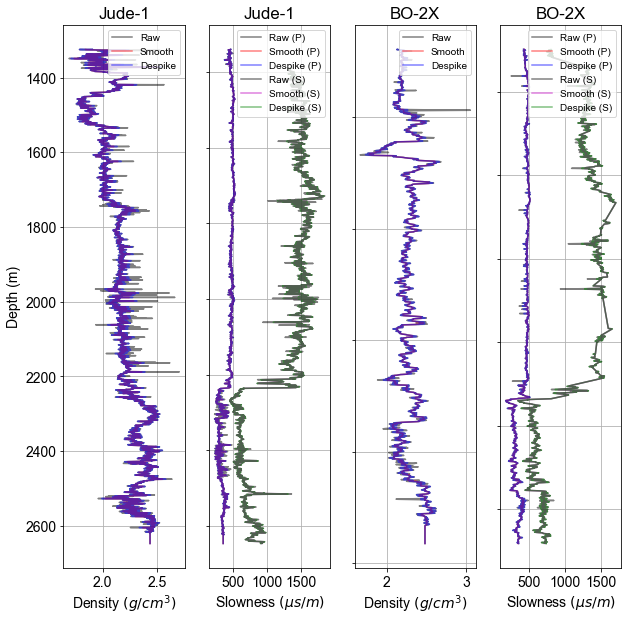

In [26]:
fig, axes = plt.subplots(nrows=1, ncols=4,figsize=(10,10))

# Density (Jude)
axes[0].plot(jude1['rho'],jude1.index,'k',alpha=0.5,label='Raw')
axes[0].plot(jude1['rho_sm'],jude1.index, 'r',alpha=0.5,label='Smooth')
axes[0].plot(jude1['rho_edt'],jude1.index, 'b',alpha=0.5,label='Despike')
axes[0].invert_yaxis()
axes[0].set_ylabel('Depth (m)')
axes[0].set_xlabel('Density '+ r'$(g/cm^3)$')
axes[0].axis('tight')
axes[0].grid()
axes[0].legend(loc=1,fontsize=10)
axes[0].set_title('Jude-1')

# P-slowness (Jude)
axes[1].plot(jude1['DT'],jude1.index,'k',alpha=0.5,label='Raw (P)')
axes[1].plot(jude1['DT_sm'],jude1.index,'r',alpha=0.5,label='Smooth (P)')
axes[1].plot(jude1['DT_edt'],jude1.index,'b',alpha=0.5,label='Despike (P)')
# S-slowness (Jude)
axes[1].plot(jude1['DTS'],jude1.index,'k',alpha=0.5,label='Raw (S)')
axes[1].plot(jude1['DTS_sm'],jude1.index,'m',alpha=0.5,label='Smooth (S)')
axes[1].plot(jude1['DTS_edt'],jude1.index,'g',alpha=0.5,label='Despike (S)')
axes[1].set_yticklabels('')
axes[1].invert_yaxis()
axes[1].set_xlabel('Slowness ' + r'$(\mu s/m)$')
axes[1].axis('tight')
axes[1].grid()
axes[1].legend(loc=1,fontsize=10)
axes[1].set_title('Jude-1')

# Density (BO-2X)
axes[2].plot(bo2['rho'],bo2.index,'k',alpha=0.5,label='Raw')
axes[2].plot(bo2['rho_sm'],bo2.index, 'r',alpha=0.5,label='Smooth')
axes[2].plot(bo2['rho_edt'],bo2.index, 'b',alpha=0.5,label='Despike')
axes[2].set_yticklabels('')
axes[2].invert_yaxis()
axes[2].set_xlabel('Density '+ r'$(g/cm^3)$')
axes[2].axis('tight')
axes[2].grid()
axes[2].legend(loc=1,fontsize=10)
axes[2].set_title('BO-2X')

# P-slowness (BO-2X)
axes[3].plot(bo2['DT'],bo2.index,'k',alpha=0.5,label='Raw (P)')
axes[3].plot(bo2['DT_sm'],bo2.index,'r',alpha=0.5,label='Smooth (P)')
axes[3].plot(bo2['DT_edt'],bo2.index,'b',alpha=0.5,label='Despike (P)')
# S-slowness (BO-2X)
axes[3].plot(bo2['DTS'],bo2.index,'k',alpha=0.5,label='Raw (S)')
axes[3].plot(bo2['DTS_sm'],bo2.index,'m',alpha=0.5,label='Smooth (S)')
axes[3].plot(bo2['DTS_edt'],bo2.index,'g',alpha=0.5,label='Despike (S)')
axes[3].set_yticklabels('')
axes[3].invert_yaxis()
axes[3].set_xlabel('Slowness ' + r'$(\mu s/m)$')
axes[3].axis('tight')
axes[3].grid()
axes[3].legend(loc=1,fontsize=10)
axes[3].set_title('BO-2X')


plt.show()

In [27]:
8326.93*0.3048

2538.048264

## Deine formation tops and extract zones



In [31]:
# Define main formation tops

tops = pd.DataFrame([[2330.393, 2356.22, 2373.93, 2430.51, 2555.35],
                     [np.nan, np.nan , 2538.048264, 8490, 8605],
                     [2429.8656, np.nan , 2519.4768, 2574.9504, 2720.34]],
                    ['BO2','BO3','JUDE1'],['Hidra','Sola','Tuxen','Valhall','BCU'])

tmp = pd.read_csv('Zones_Adda-Bo-Boje-Jude-N_Jens_Mærsk.csv', encoding = "ISO-8859-1",sep=';', delimiter=None, engine='python')
zonation_bo2 = tmp[tmp['wellName']=='BO-2X']
zonation_bo2.drop(['wellName','datasetName'],axis=1,inplace=True)
zonation_bo2.drop([82,83,93,94],inplace=True)

zonation_bo3 = tmp[tmp['wellName']=='BO-3X']
zonation_bo3.drop(['wellName','datasetName'],axis=1,inplace=True)
zonation_bo3.drop([95,105,106],inplace=True)

zonation_jude1 = tmp[tmp['wellName']=='JUDE-1']
zonation_jude1.drop(['wellName','datasetName'],axis=1,inplace=True)
zonation_jude1.drop([175,176,186,187],inplace=True)



## BO2 reservoir definition

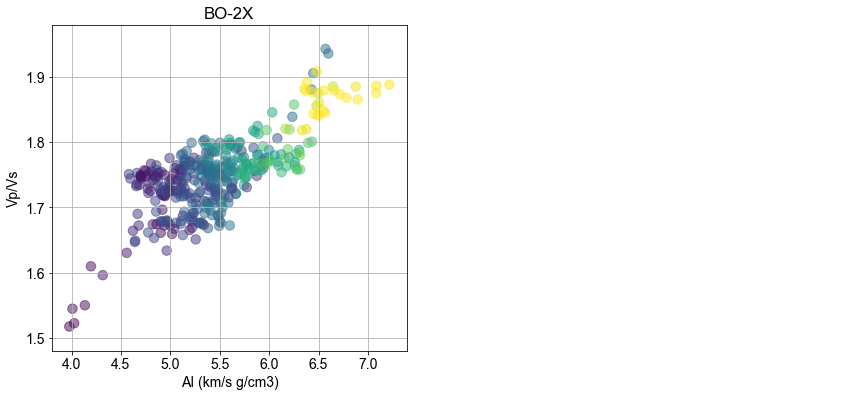

In [32]:
# Define elastic logs
bo2['Vp'] = (1e3 / bo2['DT'])
bo2['Vs'] = (1e3 / bo2['DTS_edt'])
bo2['AI'] = bo2['Vp'] * bo2['rho']
bo2['PS'] = bo2['Vp'] / bo2['Vs']

bo2['G'] = bo2['Vs']**2 * bo2['rho']
bo2['K'] = bo2['Vp']**2 * bo2['rho'] - (4/3)*bo2['G']
bo2['M'] = bo2['K'] + (4/3)*bo2['G']

# Crop reservoir interval
bo2_resSec = bo2[(bo2.index > tops[['Tuxen']].loc['BO2'][0]) & (bo2.index < tops[['Valhall']].loc['BO2'][0])]

fig, ax = plt.subplots(nrows = 1, ncols = 2,figsize=(14,6))

sc = ax[0].scatter(bo2_resSec['AI'],bo2_resSec['PS'],alpha=0.5,s=90,c=bo2_resSec['SW'])
ax[0].set_xlabel('AI (km/s g/cm3)',fontsize=14)
ax[0].set_ylabel('Vp/Vs',fontsize=14)
ax[0].set_title('BO-2X')
ax[0].grid()
ax[0].axis('tight')

ax[1].axis('off')

plt.show()


In [33]:
# Crop reservoir interval
bo2_resSec = bo2[(bo2.index > tops[['Tuxen']].loc['BO2'][0] - 20) & (bo2.index < tops[['Valhall']].loc['BO2'][0] + 20)]

# Subdivide reservoir zonations
bo2_resSec['F'] = np.zeros(len(bo2_resSec))
bo2_resSec['F_label'] = ["" for x in range(len(bo2_resSec))]
bo2_intf = [tops['Tuxen'].loc['BO2'], 2380.2, 2387.1, 2391.6, 2397.1,2398.2,2406.5,2420.1,2426.9] # interfaces
bo2_Fstr = 'Sola,UT,MTbU,MTbL,MTa,MM,LTd,LTc,LTb,Valhall'
bo2_Fstr = bo2_Fstr.split(',')

bo2_resSec.loc[(bo2_resSec.index < bo2_intf[0]),'F'] = 0
bo2_resSec.loc[(bo2_resSec.index >= bo2_intf[0]) & (bo2_resSec.index <= bo2_intf[1]),'F'] = 1
bo2_resSec.loc[(bo2_resSec.index > bo2_intf[1]) & (bo2_resSec.index <= bo2_intf[2]),'F'] = 2
bo2_resSec.loc[(bo2_resSec.index > bo2_intf[2]) & (bo2_resSec.index <= bo2_intf[3]),'F'] = 3
bo2_resSec.loc[(bo2_resSec.index > bo2_intf[3]) & (bo2_resSec.index <= bo2_intf[4]),'F'] = 4
bo2_resSec.loc[(bo2_resSec.index > bo2_intf[4]) & (bo2_resSec.index <= bo2_intf[5]),'F'] = 5
bo2_resSec.loc[(bo2_resSec.index > bo2_intf[5]) & (bo2_resSec.index <= bo2_intf[6]),'F'] = 6
bo2_resSec.loc[(bo2_resSec.index > bo2_intf[6]) & (bo2_resSec.index <= bo2_intf[7]),'F'] = 7
bo2_resSec.loc[(bo2_resSec.index > bo2_intf[7]) & (bo2_resSec.index <= bo2_intf[8]),'F'] = 8
bo2_resSec.loc[(bo2_resSec.index > bo2_intf[8]),'F'] = 9

bo2_resSec.loc[(bo2_resSec.index < bo2_intf[0]),'F_label'] = bo2_Fstr[0]
bo2_resSec.loc[(bo2_resSec.index >= bo2_intf[0]) & (bo2_resSec.index <= bo2_intf[1]),'F_label'] = bo2_Fstr[1]
bo2_resSec.loc[(bo2_resSec.index >= bo2_intf[1]) & (bo2_resSec.index <= bo2_intf[2]),'F_label'] = bo2_Fstr[2]
bo2_resSec.loc[(bo2_resSec.index >= bo2_intf[2]) & (bo2_resSec.index <= bo2_intf[3]),'F_label'] = bo2_Fstr[3]
bo2_resSec.loc[(bo2_resSec.index >= bo2_intf[3]) & (bo2_resSec.index <= bo2_intf[4]),'F_label'] = bo2_Fstr[4]
bo2_resSec.loc[(bo2_resSec.index >= bo2_intf[4]) & (bo2_resSec.index <= bo2_intf[5]),'F_label'] = bo2_Fstr[5]
bo2_resSec.loc[(bo2_resSec.index >= bo2_intf[5]) & (bo2_resSec.index <= bo2_intf[6]),'F_label'] = bo2_Fstr[6]
bo2_resSec.loc[(bo2_resSec.index >= bo2_intf[6]) & (bo2_resSec.index <= bo2_intf[7]),'F_label'] = bo2_Fstr[7]
bo2_resSec.loc[(bo2_resSec.index >= bo2_intf[7]) & (bo2_resSec.index <= bo2_intf[8]),'F_label'] = bo2_Fstr[8]
bo2_resSec.loc[(bo2_resSec.index > bo2_intf[8]),'F_label'] = bo2_Fstr[9]

bo2_dz = []
for m in range(0,len(bo2_Fstr)):
    bo2_dz.append(np.diff(bo2_resSec[bo2_resSec['F']==m].index).sum())


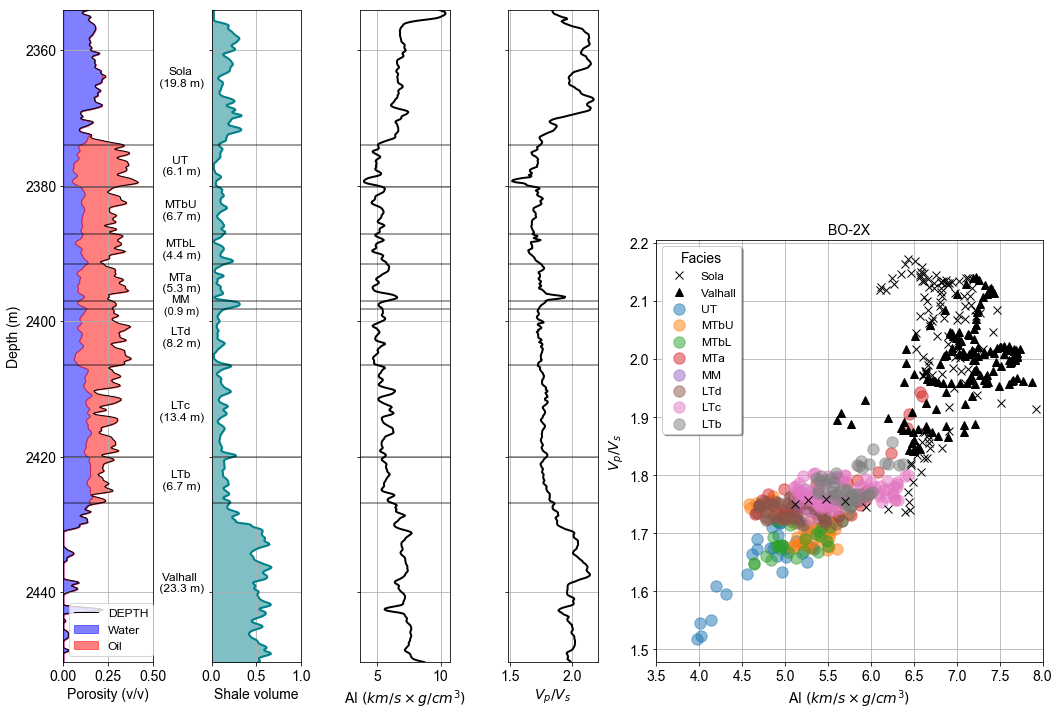

In [34]:
fig = plt.figure(figsize=(16,12))
#
gs1 = gridspec.GridSpec(nrows=3, ncols=7, left = 0.05, wspace=0.65)
ax1a = fig.add_subplot(gs1[:, 0])
ax1b = fig.add_subplot(gs1[:, 1])
ax2 = fig.add_subplot(gs1[:, 2])
ax3 = fig.add_subplot(gs1[:, 3])
ax4 = fig.add_subplot(gs1[1:4, 4:7])

# Porosity & fluid saturation
x1 = bo2_resSec['PHI']*(1-bo2_resSec['SW'])
x2 = bo2_resSec['PHI']*bo2_resSec['SW']
ax1a.fill_betweenx(bo2_resSec.index,x2,0, alpha=0.5,color='b',label='Water')
ax1a.fill_betweenx(bo2_resSec.index,x2,bo2_resSec['PHI'], alpha=0.5,color='r',label='Oil')
ax1a.plot(bo2_resSec['PHI'],bo2_resSec.index,'-k',lw=1)
ax1a.axis('tight')
ax1a.set_ylim(bo2_resSec.index.min(),bo2_resSec.index.max())
ax1a.invert_yaxis()
ax1a.set_xlim(0,0.5)
ax1a.set_xlabel('Porosity (v/v)', fontsize = 14)
ax1a.set_ylabel('Depth (m)', fontsize = 14)
ax1a.grid()
ax1a.legend(loc=0,fontsize=12)

# Shale volume 
ax1b.fill_betweenx(bo2_resSec.index,bo2_resSec['VSH'],0,color='#02818a',alpha=0.5)
ax1b.plot(bo2_resSec['VSH'],bo2_resSec.index,color='#02818a',lw=2)
ax1b.axis('tight')
ax1b.set_ylim(bo2_resSec.index.min(),bo2_resSec.index.max())
ax1b.invert_yaxis()
ax1b.set_yticklabels('')
ax1b.set_xlim(0,1)
ax1b.set_xlabel('Shale volume', fontsize = 14)
ax1b.grid()

# AI
ax2.plot(bo2_resSec['AI'],bo2_resSec.index,'k-',lw=2)
ax2.axis('tight')
ax2.set_ylim(bo2_resSec.index.min(),bo2_resSec.index.max())
ax2.invert_yaxis()
ax2.set_xlabel('AI '+ r'$(km/s \times g/cm^3)$', fontsize = 14)
ax2.set_yticklabels('')
ax2.grid()

# Vp/Vs
ax3.plot(bo2_resSec['PS'],bo2_resSec.index,'k-',lw=2)
ax3.axis('tight')
ax3.set_ylim(bo2_resSec.index.min(),bo2_resSec.index.max())
ax3.invert_yaxis()
ax3.set_xlabel(r'$V_p/V_s$', fontsize = 14)
ax3.set_yticklabels('')
ax3.grid()

for n in range(0,len(bo2_intf)):
    ax1a.axhline(y = bo2_intf[n], color = 'k', lw = 1.5, linestyle = '-',
                   alpha = 0.5)  
    ax1b.axhline(y = bo2_intf[n], color = 'k', lw = 1.5, linestyle = '-',
                   alpha = 0.5)    
    ax2.axhline(y = bo2_intf[n], color = 'k', lw = 1.5, linestyle = '-',
                   alpha = 0.5)
    ax3.axhline(y = bo2_intf[n], color = 'k', lw = 1.5, linestyle = '-',
                   alpha = 0.5)

    
ax1a.text(x = ax1a.set_xlim()[1]+0.15, y = (bo2_intf[0] + bo2_resSec.index.min())/2, s = '{0}\n ({1} m)'.format(bo2_Fstr[0],str(round(bo2_dz[0],1))),
        fontsize = '12',
        horizontalalignment = 'center',
        verticalalignment = 'center',
        bbox = dict(facecolor = 'white',alpha = 0, lw = 0),
        weight = 'light',
        rotation=0)

ax1a.text(x = ax1a.set_xlim()[1]+0.15, y =(bo2_intf[0]+bo2_intf[1])/2, s = '{0}\n ({1} m)'.format(bo2_Fstr[1],str(round(bo2_dz[1],1))),
        fontsize = '12',
        horizontalalignment = 'center',
        verticalalignment = 'center',
        bbox = dict(facecolor = 'white',alpha = 0, lw = 0),
        weight = 'light',
        rotation=0)

ax1a.text(x = ax1a.set_xlim()[1]+0.15, y =(bo2_intf[1]+bo2_intf[2])/2, s = '{0}\n ({1} m)'.format(bo2_Fstr[2],str(round(bo2_dz[2],1))),
        fontsize = '12',
        horizontalalignment = 'center',
        verticalalignment = 'center',
        bbox = dict(facecolor = 'white',alpha = 0, lw = 0),
        weight = 'light',
        rotation=0)

ax1a.text(x = ax1a.set_xlim()[1]+0.15, y =(bo2_intf[2]+bo2_intf[3])/2, s = '{0}\n ({1} m)'.format(bo2_Fstr[3],str(round(bo2_dz[3],1))),
        fontsize = '12',
        horizontalalignment = 'center',
        verticalalignment = 'center',
        bbox = dict(facecolor = 'white',alpha = 0, lw = 0),
        weight = 'light',
        rotation=0)

ax1a.text(x = ax1a.set_xlim()[1]+0.15, y =(bo2_intf[3]+bo2_intf[4])/2, s = '{0}\n ({1} m)'.format(bo2_Fstr[4],str(round(bo2_dz[4],1))),
        fontsize = '12',
        horizontalalignment = 'center',
        verticalalignment = 'center',
        bbox = dict(facecolor = 'white',alpha = 0, lw = 0),
        weight = 'light',
        rotation=0)

ax1a.text(x = ax1a.set_xlim()[1]+0.15, y =(bo2_intf[4]+bo2_intf[5])/2, s = '{0}\n ({1} m)'.format(bo2_Fstr[5],str(round(bo2_dz[5],1))),
        fontsize = '11',
        horizontalalignment = 'center',
        verticalalignment = 'center',
        bbox = dict(facecolor = 'white',alpha = 0, lw = 0),
        weight = 'light',
        rotation=0)

ax1a.text(x = ax1a.set_xlim()[1]+0.15, y =(bo2_intf[5]+bo2_intf[6])/2, s = '{0}\n ({1} m)'.format(bo2_Fstr[6],str(round(bo2_dz[6],1))),
        fontsize = '12',
        horizontalalignment = 'center',
        verticalalignment = 'center',
        bbox = dict(facecolor = 'white',alpha = 0, lw = 0),
        weight = 'light',
        rotation=0)

ax1a.text(x = ax1a.set_xlim()[1]+0.15, y =(bo2_intf[6]+bo2_intf[7])/2, s = '{0}\n ({1} m)'.format(bo2_Fstr[7],str(round(bo2_dz[7],1))),
        fontsize = '12',
        horizontalalignment = 'center',
        verticalalignment = 'center',
        bbox = dict(facecolor = 'white',alpha = 0, lw = 0),
        weight = 'light',
        rotation=0)

ax1a.text(x = ax1a.set_xlim()[1]+0.15, y =(bo2_intf[7]+bo2_intf[8])/2, s = '{0}\n ({1} m)'.format(bo2_Fstr[8],str(round(bo2_dz[8],1))),
        fontsize = '12',
        horizontalalignment = 'center',
        verticalalignment = 'center',
        bbox = dict(facecolor = 'white',alpha = 0, lw = 0),
        weight = 'light',
        rotation=0)

ax1a.text(x = ax1a.set_xlim()[1]+0.15, y =(bo2_intf[8]+bo2_resSec.index.max())/2, s = '{0}\n ({1} m)'.format(bo2_Fstr[9],str(round(bo2_dz[9],1))),
        fontsize = '12',
        horizontalalignment = 'center',
        verticalalignment = 'center',
        bbox = dict(facecolor = 'white',alpha = 0, lw = 0),
        weight = 'light',
        rotation=0)


# AI vs Vp/Vs

groups = bo2_resSec['F_label'].unique()

for i in range(len(groups)):
    x, y = (bo2_resSec[bo2_resSec['F_label']==groups[i]]['AI'],bo2_resSec[bo2_resSec['F_label']==groups[i]]['PS'])
    if (groups[i]=='Sola'):
        ax4.plot(bo2_resSec[bo2_resSec['F_label']==groups[i]]['AI'],bo2_resSec[bo2_resSec['F_label']==groups[i]]['PS'],'kx',ms=8,label=groups[i])
    elif (groups[i]=='Valhall'):
        ax4.plot(bo2_resSec[bo2_resSec['F_label']==groups[i]]['AI'],bo2_resSec[bo2_resSec['F_label']==groups[i]]['PS'],'k^',ms=8,label=groups[i],color='k')
    else:
        ax4.scatter(x, y, alpha=0.5, s=130, label=groups[i])


ax4.set_xlabel('AI '+ r'$(km/s \times g/cm^3)$', fontsize = 14)
ax4.set_ylabel(r'$V_p/V_s$', fontsize = 14)
ax4.set_title('BO-2X',fontsize=14)
ax4.set_xlim(3.5,8)
ax4.grid()
ax4.set_axisbelow(True)
lg = ax4.legend(loc=2,title='Facies',fontsize=12,fancybox=True,shadow=True)
plt.setp(lg.get_title(),fontsize=14)

#plt.savefig('Bo2_x-plot.png',dpi=400)
plt.show()

In [35]:
tops[['Valhall']].loc['BO3'][0]

8490.0

## BO3 reservoir definition

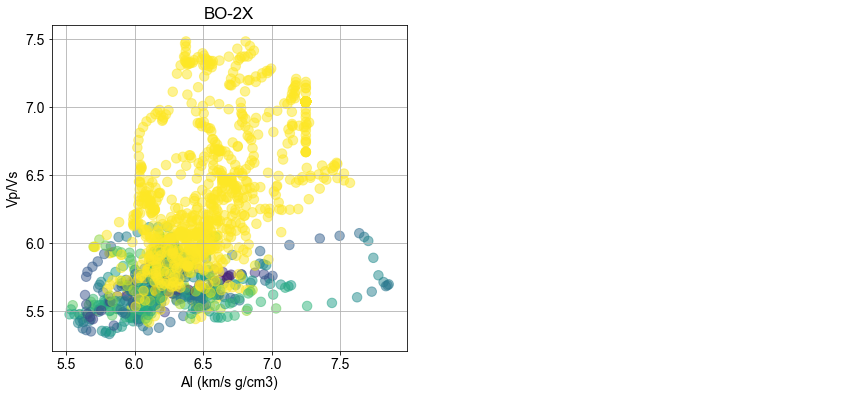

In [36]:
# Define elastic logs
bo3['Vp'] = (1e3 / bo3['DT'])
bo3['Vs'] = (1e3 / bo3['DTS_edt'])
bo3['AI'] = bo3['Vp'] * bo3['rho']
bo3['PS'] = bo3['Vp'] / bo3['Vs']

bo3['G'] = bo3['Vs']**2 * bo3['rho']
bo3['K'] = bo3['Vp']**2 * bo3['rho'] - (4/3)*bo3['G']
bo3['M'] = bo3['K'] + (4/3)*bo3['G']

# Crop reservoir interval
bo3_resSec = bo3[(bo3.index > tops[['Tuxen']].loc['BO3'][0]) & (bo3.index < tops[['Valhall']].loc['BO3'][0])]

fig, ax = plt.subplots(nrows = 1, ncols = 2,figsize=(14,6))

sc = ax[0].scatter(bo3_resSec['AI'],bo3_resSec['PS'],alpha=0.5,s=90,c=bo3_resSec['SW'])
ax[0].set_xlabel('AI (km/s g/cm3)',fontsize=14)
ax[0].set_ylabel('Vp/Vs',fontsize=14)
ax[0].set_title('BO-2X')
ax[0].grid()
ax[0].axis('tight')

ax[1].axis('off')

plt.show()


In [37]:
# Crop reservoir interval
bo2_resSec = bo2[(bo2.index > tops[['Tuxen']].loc['BO2'][0] - 20) & (bo2.index < tops[['Valhall']].loc['BO2'][0] + 20)]

# Subdivide reservoir zonations
bo2_resSec['F'] = np.zeros(len(bo2_resSec))
bo2_resSec['F_label'] = ["" for x in range(len(bo2_resSec))]
bo2_intf = [tops['Tuxen'].loc['BO2'], 2380.2, 2387.1, 2391.6, 2397.1,2398.2,2406.5,2420.1,2426.9] # interfaces
bo2_Fstr = 'Sola,UT,MTbU,MTbL,MTa,MM,LTd,LTc,LTb,Valhall'
bo2_Fstr = bo2_Fstr.split(',')

bo2_resSec.loc[(bo2_resSec.index < bo2_intf[0]),'F'] = 0
bo2_resSec.loc[(bo2_resSec.index >= bo2_intf[0]) & (bo2_resSec.index <= bo2_intf[1]),'F'] = 1
bo2_resSec.loc[(bo2_resSec.index > bo2_intf[1]) & (bo2_resSec.index <= bo2_intf[2]),'F'] = 2
bo2_resSec.loc[(bo2_resSec.index > bo2_intf[2]) & (bo2_resSec.index <= bo2_intf[3]),'F'] = 3
bo2_resSec.loc[(bo2_resSec.index > bo2_intf[3]) & (bo2_resSec.index <= bo2_intf[4]),'F'] = 4
bo2_resSec.loc[(bo2_resSec.index > bo2_intf[4]) & (bo2_resSec.index <= bo2_intf[5]),'F'] = 5
bo2_resSec.loc[(bo2_resSec.index > bo2_intf[5]) & (bo2_resSec.index <= bo2_intf[6]),'F'] = 6
bo2_resSec.loc[(bo2_resSec.index > bo2_intf[6]) & (bo2_resSec.index <= bo2_intf[7]),'F'] = 7
bo2_resSec.loc[(bo2_resSec.index > bo2_intf[7]) & (bo2_resSec.index <= bo2_intf[8]),'F'] = 8
bo2_resSec.loc[(bo2_resSec.index > bo2_intf[8]),'F'] = 9

bo2_resSec.loc[(bo2_resSec.index < bo2_intf[0]),'F_label'] = bo2_Fstr[0]
bo2_resSec.loc[(bo2_resSec.index >= bo2_intf[0]) & (bo2_resSec.index <= bo2_intf[1]),'F_label'] = bo2_Fstr[1]
bo2_resSec.loc[(bo2_resSec.index >= bo2_intf[1]) & (bo2_resSec.index <= bo2_intf[2]),'F_label'] = bo2_Fstr[2]
bo2_resSec.loc[(bo2_resSec.index >= bo2_intf[2]) & (bo2_resSec.index <= bo2_intf[3]),'F_label'] = bo2_Fstr[3]
bo2_resSec.loc[(bo2_resSec.index >= bo2_intf[3]) & (bo2_resSec.index <= bo2_intf[4]),'F_label'] = bo2_Fstr[4]
bo2_resSec.loc[(bo2_resSec.index >= bo2_intf[4]) & (bo2_resSec.index <= bo2_intf[5]),'F_label'] = bo2_Fstr[5]
bo2_resSec.loc[(bo2_resSec.index >= bo2_intf[5]) & (bo2_resSec.index <= bo2_intf[6]),'F_label'] = bo2_Fstr[6]
bo2_resSec.loc[(bo2_resSec.index >= bo2_intf[6]) & (bo2_resSec.index <= bo2_intf[7]),'F_label'] = bo2_Fstr[7]
bo2_resSec.loc[(bo2_resSec.index >= bo2_intf[7]) & (bo2_resSec.index <= bo2_intf[8]),'F_label'] = bo2_Fstr[8]
bo2_resSec.loc[(bo2_resSec.index > bo2_intf[8]),'F_label'] = bo2_Fstr[9]

bo2_dz = []
for m in range(0,len(bo2_Fstr)):
    bo2_dz.append(np.diff(bo2_resSec[bo2_resSec['F']==m].index).sum())


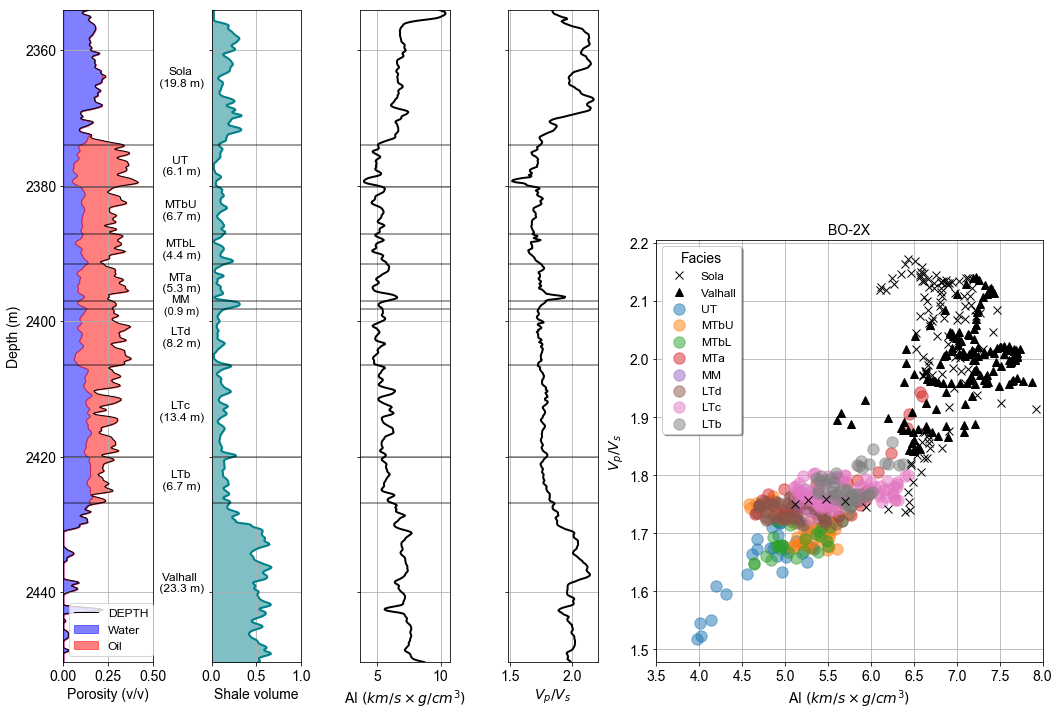

In [38]:
fig = plt.figure(figsize=(16,12))
#
gs1 = gridspec.GridSpec(nrows=3, ncols=7, left = 0.05, wspace=0.65)
ax1a = fig.add_subplot(gs1[:, 0])
ax1b = fig.add_subplot(gs1[:, 1])
ax2 = fig.add_subplot(gs1[:, 2])
ax3 = fig.add_subplot(gs1[:, 3])
ax4 = fig.add_subplot(gs1[1:4, 4:7])

# Porosity & fluid saturation
x1 = bo2_resSec['PHI']*(1-bo2_resSec['SW'])
x2 = bo2_resSec['PHI']*bo2_resSec['SW']
ax1a.fill_betweenx(bo2_resSec.index,x2,0, alpha=0.5,color='b',label='Water')
ax1a.fill_betweenx(bo2_resSec.index,x2,bo2_resSec['PHI'], alpha=0.5,color='r',label='Oil')
ax1a.plot(bo2_resSec['PHI'],bo2_resSec.index,'-k',lw=1)
ax1a.axis('tight')
ax1a.set_ylim(bo2_resSec.index.min(),bo2_resSec.index.max())
ax1a.invert_yaxis()
ax1a.set_xlim(0,0.5)
ax1a.set_xlabel('Porosity (v/v)', fontsize = 14)
ax1a.set_ylabel('Depth (m)', fontsize = 14)
ax1a.grid()
ax1a.legend(loc=0,fontsize=12)

# Shale volume 
ax1b.fill_betweenx(bo2_resSec.index,bo2_resSec['VSH'],0,color='#02818a',alpha=0.5)
ax1b.plot(bo2_resSec['VSH'],bo2_resSec.index,color='#02818a',lw=2)
ax1b.axis('tight')
ax1b.set_ylim(bo2_resSec.index.min(),bo2_resSec.index.max())
ax1b.invert_yaxis()
ax1b.set_yticklabels('')
ax1b.set_xlim(0,1)
ax1b.set_xlabel('Shale volume', fontsize = 14)
ax1b.grid()

# AI
ax2.plot(bo2_resSec['AI'],bo2_resSec.index,'k-',lw=2)
ax2.axis('tight')
ax2.set_ylim(bo2_resSec.index.min(),bo2_resSec.index.max())
ax2.invert_yaxis()
ax2.set_xlabel('AI '+ r'$(km/s \times g/cm^3)$', fontsize = 14)
ax2.set_yticklabels('')
ax2.grid()

# Vp/Vs
ax3.plot(bo2_resSec['PS'],bo2_resSec.index,'k-',lw=2)
ax3.axis('tight')
ax3.set_ylim(bo2_resSec.index.min(),bo2_resSec.index.max())
ax3.invert_yaxis()
ax3.set_xlabel(r'$V_p/V_s$', fontsize = 14)
ax3.set_yticklabels('')
ax3.grid()

for n in range(0,len(bo2_intf)):
    ax1a.axhline(y = bo2_intf[n], color = 'k', lw = 1.5, linestyle = '-',
                   alpha = 0.5)  
    ax1b.axhline(y = bo2_intf[n], color = 'k', lw = 1.5, linestyle = '-',
                   alpha = 0.5)    
    ax2.axhline(y = bo2_intf[n], color = 'k', lw = 1.5, linestyle = '-',
                   alpha = 0.5)
    ax3.axhline(y = bo2_intf[n], color = 'k', lw = 1.5, linestyle = '-',
                   alpha = 0.5)

    
ax1a.text(x = ax1a.set_xlim()[1]+0.15, y = (bo2_intf[0] + bo2_resSec.index.min())/2, s = '{0}\n ({1} m)'.format(bo2_Fstr[0],str(round(bo2_dz[0],1))),
        fontsize = '12',
        horizontalalignment = 'center',
        verticalalignment = 'center',
        bbox = dict(facecolor = 'white',alpha = 0, lw = 0),
        weight = 'light',
        rotation=0)

ax1a.text(x = ax1a.set_xlim()[1]+0.15, y =(bo2_intf[0]+bo2_intf[1])/2, s = '{0}\n ({1} m)'.format(bo2_Fstr[1],str(round(bo2_dz[1],1))),
        fontsize = '12',
        horizontalalignment = 'center',
        verticalalignment = 'center',
        bbox = dict(facecolor = 'white',alpha = 0, lw = 0),
        weight = 'light',
        rotation=0)

ax1a.text(x = ax1a.set_xlim()[1]+0.15, y =(bo2_intf[1]+bo2_intf[2])/2, s = '{0}\n ({1} m)'.format(bo2_Fstr[2],str(round(bo2_dz[2],1))),
        fontsize = '12',
        horizontalalignment = 'center',
        verticalalignment = 'center',
        bbox = dict(facecolor = 'white',alpha = 0, lw = 0),
        weight = 'light',
        rotation=0)

ax1a.text(x = ax1a.set_xlim()[1]+0.15, y =(bo2_intf[2]+bo2_intf[3])/2, s = '{0}\n ({1} m)'.format(bo2_Fstr[3],str(round(bo2_dz[3],1))),
        fontsize = '12',
        horizontalalignment = 'center',
        verticalalignment = 'center',
        bbox = dict(facecolor = 'white',alpha = 0, lw = 0),
        weight = 'light',
        rotation=0)

ax1a.text(x = ax1a.set_xlim()[1]+0.15, y =(bo2_intf[3]+bo2_intf[4])/2, s = '{0}\n ({1} m)'.format(bo2_Fstr[4],str(round(bo2_dz[4],1))),
        fontsize = '12',
        horizontalalignment = 'center',
        verticalalignment = 'center',
        bbox = dict(facecolor = 'white',alpha = 0, lw = 0),
        weight = 'light',
        rotation=0)

ax1a.text(x = ax1a.set_xlim()[1]+0.15, y =(bo2_intf[4]+bo2_intf[5])/2, s = '{0}\n ({1} m)'.format(bo2_Fstr[5],str(round(bo2_dz[5],1))),
        fontsize = '11',
        horizontalalignment = 'center',
        verticalalignment = 'center',
        bbox = dict(facecolor = 'white',alpha = 0, lw = 0),
        weight = 'light',
        rotation=0)

ax1a.text(x = ax1a.set_xlim()[1]+0.15, y =(bo2_intf[5]+bo2_intf[6])/2, s = '{0}\n ({1} m)'.format(bo2_Fstr[6],str(round(bo2_dz[6],1))),
        fontsize = '12',
        horizontalalignment = 'center',
        verticalalignment = 'center',
        bbox = dict(facecolor = 'white',alpha = 0, lw = 0),
        weight = 'light',
        rotation=0)

ax1a.text(x = ax1a.set_xlim()[1]+0.15, y =(bo2_intf[6]+bo2_intf[7])/2, s = '{0}\n ({1} m)'.format(bo2_Fstr[7],str(round(bo2_dz[7],1))),
        fontsize = '12',
        horizontalalignment = 'center',
        verticalalignment = 'center',
        bbox = dict(facecolor = 'white',alpha = 0, lw = 0),
        weight = 'light',
        rotation=0)

ax1a.text(x = ax1a.set_xlim()[1]+0.15, y =(bo2_intf[7]+bo2_intf[8])/2, s = '{0}\n ({1} m)'.format(bo2_Fstr[8],str(round(bo2_dz[8],1))),
        fontsize = '12',
        horizontalalignment = 'center',
        verticalalignment = 'center',
        bbox = dict(facecolor = 'white',alpha = 0, lw = 0),
        weight = 'light',
        rotation=0)

ax1a.text(x = ax1a.set_xlim()[1]+0.15, y =(bo2_intf[8]+bo2_resSec.index.max())/2, s = '{0}\n ({1} m)'.format(bo2_Fstr[9],str(round(bo2_dz[9],1))),
        fontsize = '12',
        horizontalalignment = 'center',
        verticalalignment = 'center',
        bbox = dict(facecolor = 'white',alpha = 0, lw = 0),
        weight = 'light',
        rotation=0)


# AI vs Vp/Vs

groups = bo2_resSec['F_label'].unique()

for i in range(len(groups)):
    x, y = (bo2_resSec[bo2_resSec['F_label']==groups[i]]['AI'],bo2_resSec[bo2_resSec['F_label']==groups[i]]['PS'])
    if (groups[i]=='Sola'):
        ax4.plot(bo2_resSec[bo2_resSec['F_label']==groups[i]]['AI'],bo2_resSec[bo2_resSec['F_label']==groups[i]]['PS'],'kx',ms=8,label=groups[i])
    elif (groups[i]=='Valhall'):
        ax4.plot(bo2_resSec[bo2_resSec['F_label']==groups[i]]['AI'],bo2_resSec[bo2_resSec['F_label']==groups[i]]['PS'],'k^',ms=8,label=groups[i],color='k')
    else:
        ax4.scatter(x, y, alpha=0.5, s=130, label=groups[i])


ax4.set_xlabel('AI '+ r'$(km/s \times g/cm^3)$', fontsize = 14)
ax4.set_ylabel(r'$V_p/V_s$', fontsize = 14)
ax4.set_title('BO-2X',fontsize=14)
ax4.set_xlim(3.5,8)
ax4.grid()
ax4.set_axisbelow(True)
lg = ax4.legend(loc=2,title='Facies',fontsize=12,fancybox=True,shadow=True)
plt.setp(lg.get_title(),fontsize=14)

#plt.savefig('Bo2_x-plot.png',dpi=400)
plt.show()

# Jude-1

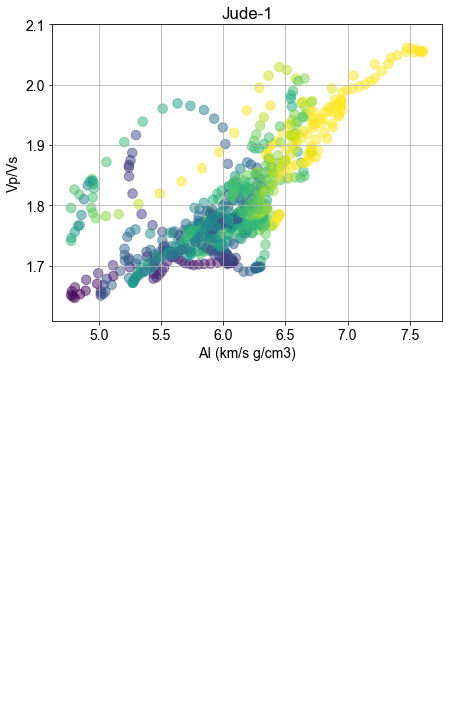

In [39]:
# Define elastic logs
jude1['Vp'] = (1e3 / jude1['DT_edt'])
jude1['Vs'] = (1e3 / jude1['DTS_edt'])
jude1['AI'] = jude1['Vp'] * jude1['rho_edt']
jude1['PS'] = jude1['Vp'] / jude1['Vs']

jude1['G'] = jude1['Vs']**2 * jude1['rho_edt']
jude1['K'] = jude1['Vp']**2 * jude1['rho_edt'] - (4/3)*jude1['G']
jude1['M'] = jude1['K'] + (4/3)*jude1['G']

# Crop reservoir interval
jude1_resSec = jude1[(jude1.index > tops[['Tuxen']].loc['JUDE1'][0]) & (jude1.index < tops[['Valhall']].loc['JUDE1'][0])]


fig, ax = plt.subplots(nrows = 2, ncols = 1,figsize=(7,12))

sc = ax[0].scatter(jude1_resSec['AI'],jude1_resSec['PS'],alpha=0.5,s=90,c=jude1_resSec['SW'])
ax[0].set_xlabel('AI (km/s g/cm3)',fontsize=14)
ax[0].set_ylabel('Vp/Vs',fontsize=14)
ax[0].set_title('Jude-1')
ax[0].grid()
ax[0].axis('tight')

ax[1].axis('off')

plt.show()


## Jude-1 reservoir definition

In [40]:
# Crop reservoir interval
jude1_resSec = jude1[(jude1.index > tops[['Tuxen']].loc['JUDE1'][0] - 20) & (jude1.index < tops[['Valhall']].loc['JUDE1'][0] + 20)]

# Subdivide reservoir zonations
jude1_resSec['F'] = np.zeros(len(jude1_resSec))
jude1_resSec['F_label'] = ["" for x in range(len(jude1_resSec))]
jude1_intf = [tops['Tuxen'].loc['JUDE1'], 2527.09, 2534.41, 2541.72, 2550.26,2552.70,2561.84,2568.55,2574.95] # interfaces
jude1_Fstr = 'Sola,UT,MTbU,MTbL,MTa,MM,LTd,LTc,LTb,Valhall'
jude1_Fstr = jude1_Fstr.split(',')

jude1_resSec.loc[(jude1_resSec.index < jude1_intf[0]),'F'] = 0
jude1_resSec.loc[(jude1_resSec.index >= jude1_intf[0]) & (jude1_resSec.index <= jude1_intf[1]),'F'] = 1
jude1_resSec.loc[(jude1_resSec.index > jude1_intf[1]) & (jude1_resSec.index <= jude1_intf[2]),'F'] = 2
jude1_resSec.loc[(jude1_resSec.index > jude1_intf[2]) & (jude1_resSec.index <= jude1_intf[3]),'F'] = 3
jude1_resSec.loc[(jude1_resSec.index > jude1_intf[3]) & (jude1_resSec.index <= jude1_intf[4]),'F'] = 4
jude1_resSec.loc[(jude1_resSec.index > jude1_intf[4]) & (jude1_resSec.index <= jude1_intf[5]),'F'] = 5
jude1_resSec.loc[(jude1_resSec.index > jude1_intf[5]) & (jude1_resSec.index <= jude1_intf[6]),'F'] = 6
jude1_resSec.loc[(jude1_resSec.index > jude1_intf[6]) & (jude1_resSec.index <= jude1_intf[7]),'F'] = 7
jude1_resSec.loc[(jude1_resSec.index > jude1_intf[7]) & (jude1_resSec.index <= jude1_intf[8]),'F'] = 8
jude1_resSec.loc[(jude1_resSec.index > jude1_intf[8]),'F'] = 9

jude1_resSec.loc[(jude1_resSec.index < jude1_intf[0]),'F_label'] = jude1_Fstr[0]
jude1_resSec.loc[(jude1_resSec.index >= jude1_intf[0]) & (jude1_resSec.index <= jude1_intf[1]),'F_label'] = jude1_Fstr[1]
jude1_resSec.loc[(jude1_resSec.index >= jude1_intf[1]) & (jude1_resSec.index <= jude1_intf[2]),'F_label'] = jude1_Fstr[2]
jude1_resSec.loc[(jude1_resSec.index >= jude1_intf[2]) & (jude1_resSec.index <= jude1_intf[3]),'F_label'] = jude1_Fstr[3]
jude1_resSec.loc[(jude1_resSec.index >= jude1_intf[3]) & (jude1_resSec.index <= jude1_intf[4]),'F_label'] = jude1_Fstr[4]
jude1_resSec.loc[(jude1_resSec.index >= jude1_intf[4]) & (jude1_resSec.index <= jude1_intf[5]),'F_label'] = jude1_Fstr[5]
jude1_resSec.loc[(jude1_resSec.index >= jude1_intf[5]) & (jude1_resSec.index <= jude1_intf[6]),'F_label'] = jude1_Fstr[6]
jude1_resSec.loc[(jude1_resSec.index >= jude1_intf[6]) & (jude1_resSec.index <= jude1_intf[7]),'F_label'] = jude1_Fstr[7]
jude1_resSec.loc[(jude1_resSec.index >= jude1_intf[7]) & (jude1_resSec.index <= jude1_intf[8]),'F_label'] = jude1_Fstr[8]
jude1_resSec.loc[(jude1_resSec.index > jude1_intf[8]),'F_label'] = jude1_Fstr[9]

jude1_dz = []
for m in range(0,len(jude1_Fstr)):
    jude1_dz.append(np.diff(jude1_resSec[jude1_resSec['F']==m].index).sum())


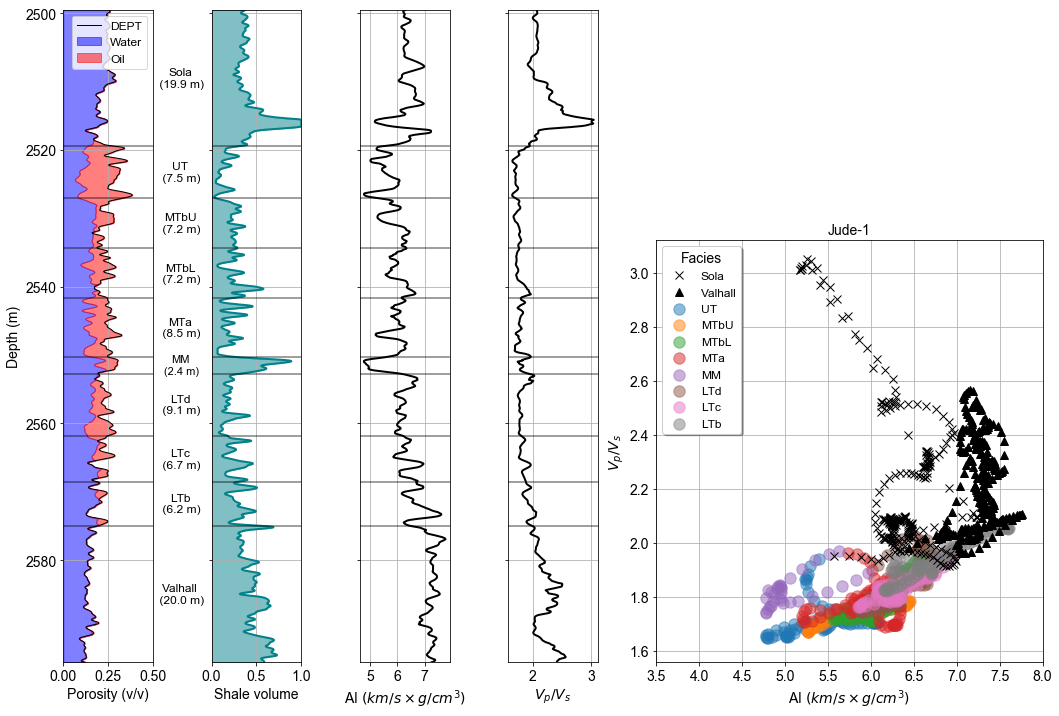

In [41]:
fig = plt.figure(figsize=(16,12))
#
gs1 = gridspec.GridSpec(nrows=3, ncols=7, left = 0.05, wspace=0.65)
ax1a = fig.add_subplot(gs1[:, 0])
ax1b = fig.add_subplot(gs1[:, 1])
ax2 = fig.add_subplot(gs1[:, 2])
ax3 = fig.add_subplot(gs1[:, 3])
ax4 = fig.add_subplot(gs1[1:4, 4:7])

# Porosity & fluid saturation
x1 = jude1_resSec['PHI']*(1-jude1_resSec['SW'])
x2 = jude1_resSec['PHI']*jude1_resSec['SW']
ax1a.fill_betweenx(jude1_resSec.index,x2,0, alpha=0.5,color='b',label='Water')
ax1a.fill_betweenx(jude1_resSec.index,x2,jude1_resSec['PHI'], alpha=0.5,color='r',label='Oil')
ax1a.plot(jude1_resSec['PHI'],jude1_resSec.index,'-k',lw=1)
ax1a.axis('tight')
ax1a.set_ylim(jude1_resSec.index.min(),jude1_resSec.index.max())
ax1a.invert_yaxis()
ax1a.set_xlim(0,0.5)
ax1a.set_xlabel('Porosity (v/v)', fontsize = 14)
ax1a.set_ylabel('Depth (m)', fontsize = 14)
ax1a.grid()
ax1a.legend(loc=0,fontsize=12)

# Shale volume 
ax1b.fill_betweenx(jude1_resSec.index,jude1_resSec['VSH'],0,color='#02818a',alpha=0.5)
ax1b.plot(jude1_resSec['VSH'],jude1_resSec.index,color='#02818a',lw=2)
ax1b.axis('tight')
ax1b.set_ylim(jude1_resSec.index.min(),jude1_resSec.index.max())
ax1b.invert_yaxis()
ax1b.set_yticklabels('')
ax1b.set_xlim(0,1)
ax1b.set_xlabel('Shale volume', fontsize = 14)
ax1b.grid()

# AI
ax2.plot(jude1_resSec['AI'],jude1_resSec.index,'k-',lw=2)
ax2.axis('tight')
ax2.set_ylim(jude1_resSec.index.min(),jude1_resSec.index.max())
ax2.invert_yaxis()
ax2.set_xlabel('AI '+ r'$(km/s \times g/cm^3)$', fontsize = 14)
ax2.set_yticklabels('')
ax2.grid()

# Vp/Vs
ax3.plot(jude1_resSec['PS'],jude1_resSec.index,'k-',lw=2)
ax3.axis('tight')
ax3.set_ylim(jude1_resSec.index.min(),jude1_resSec.index.max())
ax3.invert_yaxis()
ax3.set_xlabel(r'$V_p/V_s$', fontsize = 14)
ax3.set_yticklabels('')
ax3.grid()

for n in range(0,len(jude1_intf)):
    ax1a.axhline(y = jude1_intf[n], color = 'k', lw = 1.5, linestyle = '-',
                   alpha = 0.5)  
    ax1b.axhline(y = jude1_intf[n], color = 'k', lw = 1.5, linestyle = '-',
                   alpha = 0.5)    
    ax2.axhline(y = jude1_intf[n], color = 'k', lw = 1.5, linestyle = '-',
                   alpha = 0.5)
    ax3.axhline(y = jude1_intf[n], color = 'k', lw = 1.5, linestyle = '-',
                   alpha = 0.5)

    
ax1a.text(x = ax1a.set_xlim()[1]+0.15, y = (jude1_intf[0] + jude1_resSec.index.min())/2, s = '{0}\n ({1} m)'.format(jude1_Fstr[0],str(round(jude1_dz[0],1))),
        fontsize = '12',
        horizontalalignment = 'center',
        verticalalignment = 'center',
        bbox = dict(facecolor = 'white',alpha = 0, lw = 0),
        weight = 'light',
        rotation=0)

ax1a.text(x = ax1a.set_xlim()[1]+0.15, y =(jude1_intf[0]+jude1_intf[1])/2, s = '{0}\n ({1} m)'.format(jude1_Fstr[1],str(round(jude1_dz[1],1))),
        fontsize = '12',
        horizontalalignment = 'center',
        verticalalignment = 'center',
        bbox = dict(facecolor = 'white',alpha = 0, lw = 0),
        weight = 'light',
        rotation=0)

ax1a.text(x = ax1a.set_xlim()[1]+0.15, y =(jude1_intf[1]+jude1_intf[2])/2, s = '{0}\n ({1} m)'.format(jude1_Fstr[2],str(round(jude1_dz[2],1))),
        fontsize = '12',
        horizontalalignment = 'center',
        verticalalignment = 'center',
        bbox = dict(facecolor = 'white',alpha = 0, lw = 0),
        weight = 'light',
        rotation=0)

ax1a.text(x = ax1a.set_xlim()[1]+0.15, y =(jude1_intf[2]+jude1_intf[3])/2, s = '{0}\n ({1} m)'.format(jude1_Fstr[3],str(round(jude1_dz[3],1))),
        fontsize = '12',
        horizontalalignment = 'center',
        verticalalignment = 'center',
        bbox = dict(facecolor = 'white',alpha = 0, lw = 0),
        weight = 'light',
        rotation=0)

ax1a.text(x = ax1a.set_xlim()[1]+0.15, y =(jude1_intf[3]+jude1_intf[4])/2, s = '{0}\n ({1} m)'.format(jude1_Fstr[4],str(round(jude1_dz[4],1))),
        fontsize = '12',
        horizontalalignment = 'center',
        verticalalignment = 'center',
        bbox = dict(facecolor = 'white',alpha = 0, lw = 0),
        weight = 'light',
        rotation=0)

ax1a.text(x = ax1a.set_xlim()[1]+0.15, y =(jude1_intf[4]+jude1_intf[5])/2, s = '{0}\n ({1} m)'.format(jude1_Fstr[5],str(round(jude1_dz[5],1))),
        fontsize = '11',
        horizontalalignment = 'center',
        verticalalignment = 'center',
        bbox = dict(facecolor = 'white',alpha = 0, lw = 0),
        weight = 'light',
        rotation=0)

ax1a.text(x = ax1a.set_xlim()[1]+0.15, y =(jude1_intf[5]+jude1_intf[6])/2, s = '{0}\n ({1} m)'.format(jude1_Fstr[6],str(round(jude1_dz[6],1))),
        fontsize = '12',
        horizontalalignment = 'center',
        verticalalignment = 'center',
        bbox = dict(facecolor = 'white',alpha = 0, lw = 0),
        weight = 'light',
        rotation=0)

ax1a.text(x = ax1a.set_xlim()[1]+0.15, y =(jude1_intf[6]+jude1_intf[7])/2, s = '{0}\n ({1} m)'.format(jude1_Fstr[7],str(round(jude1_dz[7],1))),
        fontsize = '12',
        horizontalalignment = 'center',
        verticalalignment = 'center',
        bbox = dict(facecolor = 'white',alpha = 0, lw = 0),
        weight = 'light',
        rotation=0)

ax1a.text(x = ax1a.set_xlim()[1]+0.15, y =(jude1_intf[7]+jude1_intf[8])/2, s = '{0}\n ({1} m)'.format(jude1_Fstr[8],str(round(jude1_dz[8],1))),
        fontsize = '12',
        horizontalalignment = 'center',
        verticalalignment = 'center',
        bbox = dict(facecolor = 'white',alpha = 0, lw = 0),
        weight = 'light',
        rotation=0)

ax1a.text(x = ax1a.set_xlim()[1]+0.15, y =(jude1_intf[8]+jude1_resSec.index.max())/2, s = '{0}\n ({1} m)'.format(jude1_Fstr[9],str(round(jude1_dz[9],1))),
        fontsize = '12',
        horizontalalignment = 'center',
        verticalalignment = 'center',
        bbox = dict(facecolor = 'white',alpha = 0, lw = 0),
        weight = 'light',
        rotation=0)


# AI vs Vp/Vs

groups = jude1_resSec['F_label'].unique()
 
for i in range(len(groups)):
    x, y = (jude1_resSec[jude1_resSec['F_label']==groups[i]]['AI'],jude1_resSec[jude1_resSec['F_label']==groups[i]]['PS'])
    if (groups[i]=='Sola'):
        ax4.plot(jude1_resSec[jude1_resSec['F_label']==groups[i]]['AI'],jude1_resSec[jude1_resSec['F_label']==groups[i]]['PS'],'kx',ms=8,label=groups[i])
    elif (groups[i]=='Valhall'):
        ax4.plot(jude1_resSec[jude1_resSec['F_label']==groups[i]]['AI'],jude1_resSec[jude1_resSec['F_label']==groups[i]]['PS'],'k^',ms=8,label=groups[i],color='k')
    else:
        ax4.scatter(x, y, alpha=0.5, s=130, label=groups[i])


ax4.set_xlabel('AI '+ r'$(km/s \times g/cm^3)$', fontsize = 14)
ax4.set_ylabel(r'$V_p/V_s$', fontsize = 14)
ax4.set_title('Jude-1',fontsize=14)
ax4.set_xlim(3.5,8)
ax4.grid()
ax4.set_axisbelow(True)
lg = ax4.legend(loc=2,title='Facies',fontsize=12,fancybox=True,shadow=True)
plt.setp(lg.get_title(),fontsize=14)

#plt.savefig('jude1_x-plot.png',dpi=400)
plt.show()

## Define some general rock physics functions

In [42]:
def vrh(volumes,k,mu):
    '''
    Calculates Voigt-Reuss-Hill bounds, (C) aadm 2015

    INPUT
    volumes: array with volumetric fractions
    k: array with bulk modulus
    mu: array with shear modulus

    OUTPUT
    k_u, k_l: upper (Voigt) and lower (Reuss) average of k
    mu_u, mu_l: upper (Voigt) and lower (Reuss) average of mu
    k0, mu0: Hill average of k and mu
    '''
    f=np.array(volumes).T
    k=np.resize(np.array(k),np.shape(f))
    mu=np.resize(np.array(mu),np.shape(f))
    ax=0 if f.ndim==1 else 1
    k_u = np.sum(f*k,axis=ax)
    k_l = 1./np.sum(f/k,axis=ax)
    mu_u = np.sum(f*mu,axis=ax)
    mu_l = 1./np.sum(f/mu,axis=ax)
    k0 = (k_u+k_l)/2.
    mu0 = (mu_u+mu_l)/2.
    return k_u, k_l, mu_u, mu_l, k0, mu0


def geqHSW(k1,g1,k2,g2,vol1):
    # Hashin-Shtrikman-Walpole bounds (Walpole 1966). More general version of the
    # Hashin-Shtrikman bounds where the constituent with the higher bulk
    # modulus does not neccessarily have to have the highest shear modulus.
    
    vol2 = 1-vol1
    Kmin = np.min([k1,k2])
    Kmax = np.max([k1,k2])
    Gmin = np.min([g1,g2])
    Gmax = np.max([g1,g2])
    
    ku = k1 + vol2/((k2-k1)**(-1) + vol1*(k1+4/3*Gmax)**(-1))
    kl = k1 + vol2/((k2-k1)**(-1) + vol1*(k1+4/3*Gmin)**(-1))
    gu = g1 + vol2/((g2-g1)**(-1) + \
    vol1*(g1 + Gmax/6 * ((9*Kmax+8*Gmax)/(Kmax+2*Gmax)))**(-1))
    gl = g1 + vol2/((g2-g1)**(-1) + \
    vol1*(g1 + Gmin/6 * ((9*Kmin+8*Gmin)/(Kmin+2*Gmin)))**(-1))
    
    return ku,kl,gu,gl

def geqGassmannDry(Ksat, Ks, Kf, Phi):
    #   Calculates the dry rock bulk modulus using Gassmann. 
    # 
    #   DryBulkModulus  - [array]; dry rock bulk modulus [GPa]
    #   Ksat            - [array]; effective (saturated) bulk modulus [GPa]
    #   Ks              - [array]; effective solid bulk modulus [GPa]
    #   Kf              - [array]; effective fluid bulk modulus [GPa]
    #   Phi             - [array]; porosity (in fraction of 1)
    DryBulkModulus   = (Ksat * ( Phi * Ks / Kf + 1 - Phi) - Ks) / \
                    (Phi * Ks / Kf + Ksat / Ks - 1 - Phi)
        
    return DryBulkModulus 

def geqGassmannFluidSubst(Ksat1,Ks,Kf1,Kf2,Phi):
    #   Calculate effective bulk modulus doing a Gassmann fluid substitution.
    # 
    #   NewEffectiveBulkModulus - [array]; effective bulk modulus after 
    #                               substituting with fluid 2 [GPa]
    #   Ksat1       - [array]; effective bulk modulus with (original) fluid 1 [GPa]
    #   Ks          - [array]; effective solid bulk modulus [GPa]
    #   Kf1         - [array]; effective bulk modulus of fluid 1 [GPa]
    #   Kf2         - [array]; effective bulk modulus of fluid 2 [GPa]
    #   Phi         - [array]; porosity  (in fraction of 1)
    
    Tmp = Ksat1/(Ks-Ksat1) - Kf1 / (Phi*(Ks-Kf1)) + \
    Kf2/(Phi*(Ks-Kf2))
    
    NewEffectiveBulkModulus = Ks*Tmp / (1+Tmp)
    
    return NewEffectiveBulkModulus

def geqVelocityImpedance(k,mu,rho):
    
    Vp = np.sqrt((k+4/3*mu)/rho)
    Vs = np.sqrt(mu/rho)
    AI = Vp*rho
    PS = Vp/Vs
    return Vp,Vs,AI,PS


## Function: IF model

In [43]:
def IF(Mspec,data):
    
    Por = data['PHI'].values
    S_w = data['SW'].values
    
    Vtot_sh = Mspec['Vsh_L'] + Mspec['Vsh_s'] 
    Vtot_r = Mspec['Vch_L'] + Mspec['Vqz_L'] + Mspec['Vch_s'] + Mspec['Vqz_s']
    
    # Normalizing the solid volume fractions according to the shale log
    c_l = (1-data['VSH'].values) * Mspec['Vch_L']/Vtot_r
    c_s = (1-data['VSH'].values) * Mspec['Vch_s']/Vtot_r
    q_l = (1-data['VSH'].values) * Mspec['Vqz_L']/Vtot_r
    q_s = (1-data['VSH'].values) * Mspec['Vqz_s']/Vtot_r
    k_l = data['VSH'].values * Mspec['Vsh_L']/Vtot_sh
    k_s = data['VSH'].values * Mspec['Vsh_s']/Vtot_sh
    
    # Define constituent properties
    Rho_ca = Mspec['chalk'][0];K_ca = Mspec['chalk'][1];G_ca = Mspec['chalk'][2]
    Rho_q = Mspec['quartz'][0];K_q = Mspec['quartz'][1];G_q = Mspec['quartz'][2]
    Rho_k = Mspec['shale'][0];K_k = Mspec['shale'][1];G_k = Mspec['shale'][2]
    Rho_w = Mspec['water'][0];K_w = Mspec['water'][1]
    Rho_o = Mspec['oil'][0];K_o = Mspec['oil'][1]
    
    Por_c = Mspec['PorC']
    
    IFc = Mspec['IFc']
    IFq = Mspec['IFq']
    IFs = Mspec['IFs']
    
    # Pre-allocate output
    model = {
        'K_sus':np.nan*np.ones((Por.size,Mspec['IFc'].size)),
        'K':np.nan*np.ones((Por.size,Mspec['IFc'].size)),
        'G':np.nan*np.ones((Por.size,Mspec['IFc'].size)),
        'M':np.nan*np.ones((Por.size,Mspec['IFc'].size)),
        'Vp':np.nan*np.ones((Por.size,Mspec['IFc'].size)),
        'Vs':np.nan*np.ones((Por.size,Mspec['IFc'].size)),
        'AI':np.nan*np.ones((Por.size,Mspec['IFc'].size)),
        'PS':np.nan*np.ones((Por.size,Mspec['IFc'].size)),
        'RHO':np.nan*np.ones((Por.size))
    }
    
    K_f = S_w/K_w + (1-S_w)/K_o # Reuss fluid mixing

    model['RHO'] =  Por*((Rho_w*S_w) + (Rho_o*(1-S_w))) + ((1-Por)*((c_s+c_l)*Rho_ca + Rho_k*(k_s+k_l) + Rho_q*(q_s+q_l)))

    for n in range(len(IFc)):

        model['K_sus'][:,n] = ( Por/Por_c*K_f + (1-Por/Por_c)*( (c_s*(1-IFc[n])/K_ca) + (q_s*(1-IFq)/K_q) + (k_s*(1-IFs)/K_k) ) )**(-1) * (Por/Por_c + (1-Por/Por_c)*( c_s*(1-IFc[n]) + q_s*(1-IFq) + k_s*(1-IFs)) )

        model['K'][:,n] = ( ((Por/Por_c)/(model['K_sus'][:,n] + (4/3)*G_ca)) + (1-(Por/Por_c))* ( (((1-IFc[n])*c_s + (1-IFq)*q_s + (1-IFs)*k_s)/(model['K_sus'][:,n] + (4/3)*G_ca)) + ((IFc[n]*c_s+c_l) / (K_ca + (4/3)*G_ca)) + ( (IFq*q_s+q_l) / (K_q + (4/3)*G_ca)) + ((IFs*k_s+k_l) / (K_k + (4/3)*G_ca)) ))**(-1) - (4/3)*G_ca

        zeta = (G_ca/6) * ((9*K_ca + 8*G_ca)/(K_ca + 2*G_ca));

        model['G'][:,n] = ( ((Por/Por_c)/zeta) +  (1-(Por/Por_c))*( (((1-IFc[n])*c_s + (1-IFq)*q_s + (1-IFs)*k_s)/(zeta)) + ((IFc[n]*c_s+c_l)/(G_ca + zeta)) + ((IFq*q_s+q_l)/(G_q + zeta)) + ( (IFs*k_s+k_l) / (G_k + zeta))) )**(-1) - zeta

        model['M'][:,n] = model['K'][:,n] + (4/3)*model['G'][:,n]

        model['Vp'][:,n] = np.sqrt((model['K'][:,n] + (4/3)*model['G'][:,n]) / model['RHO'])
        model['Vs'][:,n] = np.sqrt(model['G'][:,n] / model['RHO'])

        model['AI'][:,n] = model['Vp'][:,n] * model['RHO']
        model['PS'][:,n] = model['Vp'][:,n] / model['Vs'][:,n]
        
    return model


## Function: Plot calibration logs

In [44]:
def plotLogs(model,data,IF):
    fig, axes = plt.subplots(nrows=1, ncols=5,figsize=(12,10))
    
    IFidx = np.argmin(abs(Mspec['IFc']-IF))
    
    axes[0].plot(data['VSH'],data.index,'k',alpha=0.5,label='Vsh',lw=3)
    axes[0].plot(data['SW'],data.index, 'b',alpha=0.75,label='Sw',lw=3)
    axes[0].invert_yaxis()
    axes[0].set_ylabel('Depth (m)', fontsize = 14)
    axes[0].set_xlabel('Volume fraction (v/v)', fontsize = 14)
    axes[0].axis('tight')
    axes[0].grid()
    axes[0].set_axisbelow(True)
    axes[0].set_xlim(0,1)
    axes[0].legend(loc=1,fontsize=12,fancybox=True,shadow=True)

    axes[1].plot(data['PHI'],data.index,'g',alpha=0.75,lw=3)
    axes[1].invert_yaxis()
    axes[1].set_yticklabels('')
    axes[1].set_xlabel('Porosity (v/v)', fontsize = 14)
    axes[1].axis('tight')
    axes[1].grid()
    axes[1].set_axisbelow(True)
    axes[1].set_xlim(0,0.5)

    axes[2].plot(data['rho_edt'],data.index,'k',alpha=1,lw=3)
    axes[2].plot(model['RHO'],data.index,'r.',ms=6,alpha=0.5)
    yerr = model['RHO'].std() * 2 # ~ 95% confidence interval
    axes[2].fill_betweenx(data.index,model['RHO']-yerr,model['RHO']+yerr,color='skyblue',alpha=0.4)
    axes[2].invert_yaxis()
    axes[2].set_yticklabels('')
    axes[2].set_xlabel('Density '+ r'$(g/cm^3)$', fontsize = 14)
    axes[2].axis('tight')
    axes[2].grid()
    axes[2].set_axisbelow(True)

    axes[3].plot(data['Vp'],data.index,'k',alpha=1,lw=3)
    axes[3].plot(model['Vp'][:,IFidx],data.index,'r.',ms=6,alpha=0.5)
    yerr = np.nanstd(model['Vp'][:,IFidx]) * 2 # ~ 95% confidence interval
    axes[3].fill_betweenx(data.index,model['Vp'][:,IFidx]-yerr,model['Vp'][:,IFidx]+yerr,color='skyblue',alpha=0.4)
    axes[3].invert_yaxis()
    axes[3].set_yticklabels('')
    axes[3].set_xlabel('P-velocity (km/s)', fontsize = 14)
    axes[3].axis('tight')
    axes[3].grid()
    axes[3].set_axisbelow(True)

    axes[4].plot(data['Vs'],data.index,'k',alpha=1,lw=3,label='Data')
    axes[4].plot(model['Vs'][:,IFidx],data.index,'r.',ms=6,alpha=0.5,label='Model')
    yerr = np.nanstd(model['Vs'][:,IFidx]) * 2 # ~ 95% confidence interval
    axes[4].fill_betweenx(data.index,model['Vs'][:,IFidx]-yerr,model['Vs'][:,IFidx]+yerr,color='skyblue',alpha=0.4,label='95% CI')
    axes[4].invert_yaxis()
    axes[4].set_yticklabels('')
    axes[4].set_xlabel('S-velocity (km/s)', fontsize = 14)
    axes[4].axis('tight')
    axes[4].grid()
    axes[4].set_axisbelow(True)
    axes[4].legend(loc=1,fontsize=12,fancybox=True,shadow=True)

    plt.show()

## BO-2 specs

In [45]:
Mspec = {
    'chalk':[2.71,71,30],'quartz':[2.65,37.3,44.8],'shale':[2.7,15,7], # Solid properties
    'water':[1.03,2.3],'oil':[0.8,0.62], # Fluid properties
    'Vch_L':0.1,'Vqz_L':0,'Vsh_L':0.05, # Volume fraction of FRAME ("Large") components
    'Vch_s':0.7,'Vqz_s':0.1,'Vsh_s':0.05, # Volume fraction of FRAME ("Large") components
    'PorC':0.66, # Critical porosity 
    'IFc':np.linspace(0,1,6),'IFq':0.2,'IFs':0.2 # IF-values for chalk, quartz and shale
}

# Calculate the mineral/solid constituents using a Hashin-Shtrikman bound
_,bo2_resSec['k_s'],_,_ = geqHSW(65,35,Mspec['shale'][1],Mspec['shale'][2],1-(bo2_resSec['VSH']))

# Calculate the fluid bulk moduli using a Hill average
_,_,_,_,bo2_resSec['k_f'],_ = vrh([bo2_resSec['SW'], 1-bo2_resSec['SW']], [Mspec['water'][1],Mspec['oil'][1]],[_,_])

# Calculate the dry bulk modulus using Gassmann
bo2_resSec['k_d'] = geqGassmannDry(bo2_resSec['K'],bo2_resSec['k_s'],bo2_resSec['k_f'],bo2_resSec['PHI'])

# Calculate water substituted bulk modulus using Gassmann
bo2_resSec['k_w'] = geqGassmannFluidSubst(bo2_resSec['K'],bo2_resSec['k_s'],bo2_resSec['k_f'],Mspec['water'][1],bo2_resSec['PHI'])

# Extract the other seismic parameters
bo2_resSec['rho_w'] = bo2_resSec['PHI']*((Mspec['water'][0]*bo2_resSec['SW'])+Mspec['oil'][0]*(1-bo2_resSec['SW'])) + (1-bo2_resSec['PHI'])*(bo2_resSec['VSH']*Mspec['shale'][0]+(1-bo2_resSec['VSH'])*Mspec['chalk'][0])
bo2_resSec['Vp_w'],bo2_resSec['Vs_w'],bo2_resSec['AI_w'],bo2_resSec['PS_w'] = geqVelocityImpedance(bo2_resSec['k_w'],bo2_resSec['G'],bo2_resSec['rho_w'])



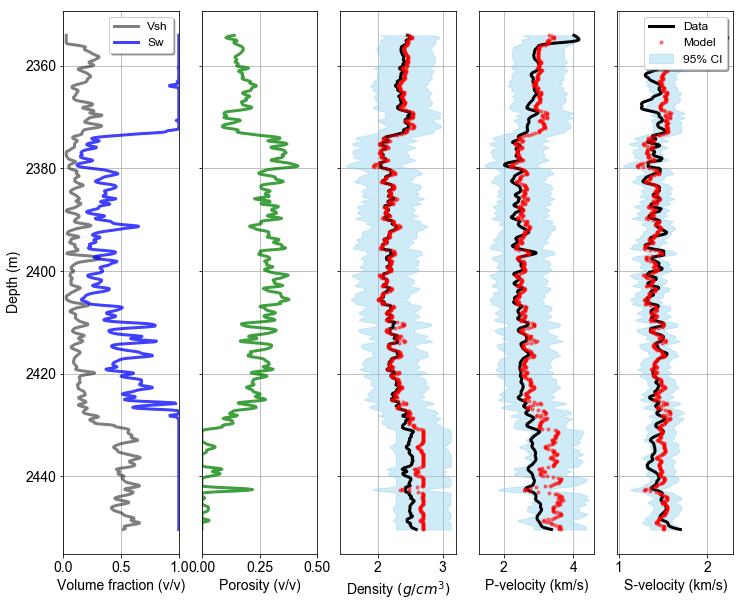

In [46]:
model = IF(Mspec,bo2_resSec)
plotLogs(model,bo2_resSec,0.4)

## Jude-1 specs

In [47]:
Mspec = {
    'chalk':[2.71,71,30],'quartz':[2.65,37.3,44.8],'shale':[2.7,15,7], # Solid properties
    'water':[1.03,2.3],'oil':[0.8,0.62], # Fluid properties
    'Vch_L':0.1,'Vqz_L':0,'Vsh_L':0.05, # Volume fraction of FRAME ("Large") components
    'Vch_s':0.7,'Vqz_s':0.1,'Vsh_s':0.05, # Volume fraction of FRAME ("Large") components
    'PorC':0.66, # Critical porosity 
    'IFc':np.linspace(0,1,6),'IFq':0.4,'IFs':0.2 # IF-values for chalk, quartz and shale
}

# Calculate the mineral/solid constituents using a Hashin-Shtrikman bound
_,jude1_resSec['k_s'],_,_ = geqHSW(65,35,Mspec['shale'][1],Mspec['shale'][2],1-(jude1_resSec['VSH']))

# Calculate the fluid bulk moduli using a Hill average
_,_,_,_,jude1_resSec['k_f'],_ = vrh([jude1_resSec['SW'], 1-jude1_resSec['SW']], [Mspec['water'][1],Mspec['oil'][1]],[_,_])

# Calculate the dry bulk modulus using Gassmann
jude1_resSec['k_d'] = geqGassmannDry(jude1_resSec['K'],jude1_resSec['k_s'],jude1_resSec['k_f'],jude1_resSec['PHI'])

# Calculate water substituted bulk modulus using Gassmann
jude1_resSec['k_w'] = geqGassmannFluidSubst(jude1_resSec['K'],jude1_resSec['k_s'],jude1_resSec['k_f'],Mspec['water'][1],jude1_resSec['PHI'])

# Extract the other seismic parameters
jude1_resSec['rho_w'] = jude1_resSec['PHI']*((Mspec['water'][0]*jude1_resSec['SW'])+Mspec['oil'][0]*(1-jude1_resSec['SW'])) + (1-jude1_resSec['PHI'])*(jude1_resSec['VSH']*Mspec['shale'][0]+(1-jude1_resSec['VSH'])*Mspec['chalk'][0])
jude1_resSec['Vp_w'],jude1_resSec['Vs_w'],jude1_resSec['AI_w'],jude1_resSec['PS_w'] = geqVelocityImpedance(jude1_resSec['k_w'],jude1_resSec['G'],jude1_resSec['rho_w'])

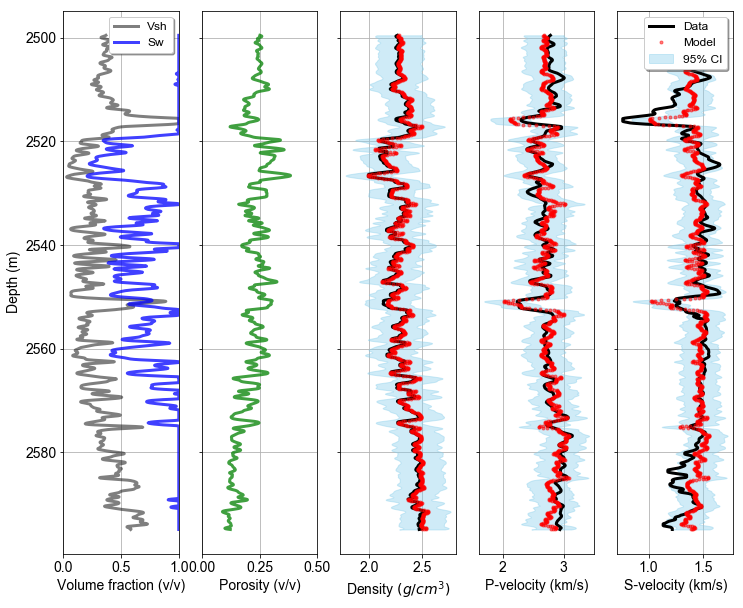

In [48]:
model = IF(Mspec,jude1_resSec)
plotLogs(model,jude1_resSec,0.4)

## Function: RPT

In [49]:
def IF_RPT(Mspec,phi,vsh,sw):
    
    Por = phi
    S_w = sw
    
    Vtot_sh = Mspec['Vsh_L'] + Mspec['Vsh_s'] 
    Vtot_r = Mspec['Vch_L'] + Mspec['Vqz_L'] + Mspec['Vch_s'] + Mspec['Vqz_s']
    
    # Normalizing the solid volume fractions according to the shale log
    c_l = (1-vsh) * Mspec['Vch_L']/Vtot_r
    c_s = (1-vsh) * Mspec['Vch_s']/Vtot_r
    q_l = (1-vsh) * Mspec['Vqz_L']/Vtot_r
    q_s = (1-vsh) * Mspec['Vqz_s']/Vtot_r
    k_l = vsh * Mspec['Vsh_L']/Vtot_sh
    k_s = vsh * Mspec['Vsh_s']/Vtot_sh
    
    
    # Define constituent properties
    Rho_ca = Mspec['chalk'][0];K_ca = Mspec['chalk'][1];G_ca = Mspec['chalk'][2]
    Rho_q = Mspec['quartz'][0];K_q = Mspec['quartz'][1];G_q = Mspec['quartz'][2]
    Rho_k = Mspec['shale'][0];K_k = Mspec['shale'][1];G_k = Mspec['shale'][2]
    Rho_w = Mspec['water'][0];K_w = Mspec['water'][1]
    Rho_o = Mspec['oil'][0];K_o = Mspec['oil'][1]
    
    Por_c = Mspec['PorC']
    
    IFc = Mspec['IFc']
    IFq = Mspec['IFq']
    IFs = Mspec['IFs']
    
    # Pre-allocate output
    model = {
        'K_sus':np.nan*np.ones((Por.size,vsh.size,S_w.size,Mspec['IFc'].size)),
        'K':np.nan*np.ones((Por.size,vsh.size,S_w.size,Mspec['IFc'].size)),
        'G':np.nan*np.ones((Por.size,vsh.size,S_w.size,Mspec['IFc'].size)),
        'M':np.nan*np.ones((Por.size,vsh.size,S_w.size,Mspec['IFc'].size)),
        'Vp':np.nan*np.ones((Por.size,vsh.size,S_w.size,Mspec['IFc'].size)),
        'Vs':np.nan*np.ones((Por.size,vsh.size,S_w.size,Mspec['IFc'].size)),
        'AI':np.nan*np.ones((Por.size,vsh.size,S_w.size,Mspec['IFc'].size)),
        'PS':np.nan*np.ones((Por.size,vsh.size,S_w.size,Mspec['IFc'].size)),
        'RHO':np.nan*np.ones((Por.size,vsh.size,S_w.size))
    } 

    
    K_f = S_w/K_w + (1-S_w)/K_o # Reuss fluid mixing    
    
    # Fluid index: w
    for w in range(len(S_w)):

        # Lithology index: v
        for v in range(len(vsh)):
            
            model['RHO'][:,v,w] =  Por*((Rho_w*S_w[w]) + (Rho_o*(1-S_w[w]))) + ((1-Por)*((c_s[v]+c_l[v])*Rho_ca + Rho_k*(k_s[v]+k_l[v]) + Rho_q*(q_s[v]+q_l[v])))

            # IFc index: i
            for i in range(len(IFc)):   
                                
                model['K_sus'][:,v,w,i] = ( Por/Por_c*K_f[w] + (1-Por/Por_c)*((c_s[v]*(1-IFc[i])/K_ca) + (q_s[v]*(1-IFq)/K_q) + (k_s[v]*(1-IFs)/K_k) ) )**(-1) * (Por/Por_c + (1-Por/Por_c)*(c_s[v]*(1-IFc[i]) + q_s[v]*(1-IFq) + k_s[v]*(1-IFs)) )
                
                model['K'][:,v,w,i] = ( ((Por/Por_c)/(model['K_sus'][:,v,w,i] + (4/3)*G_ca)) + (1-(Por/Por_c))* ( (((1-IFc[i])*c_s[v] + (1-IFq)*q_s[v] + (1-IFs)*k_s[v])/(model['K_sus'][:,v,w,i] + (4/3)*G_ca)) + ((IFc[i]*c_s[v]+c_l[v]) / (K_ca + (4/3)*G_ca)) + ( (IFq*q_s[v]+q_l[v]) / (K_q + (4/3)*G_ca)) + ((IFs*k_s[v]+k_l[v]) / (K_k + (4/3)*G_ca)) ))**(-1) - (4/3)*G_ca

                zeta = (G_ca/6) * ((9*K_ca + 8*G_ca)/(K_ca + 2*G_ca));
                
                model['G'][:,v,w,i] = ( ((Por/Por_c)/zeta) +  (1-(Por/Por_c))*( (((1-IFc[i])*c_s[v] + (1-IFq)*q_s[v] + (1-IFs)*k_s[v])/(zeta)) + ((IFc[i]*c_s[v]+c_l[v])/(G_ca + zeta)) + ((IFq*q_s[v]+q_l[v])/(G_q + zeta)) + ( (IFs*k_s[v]+k_l[v]) / (G_k + zeta))) )**(-1) - zeta

                model['M'][:,v,w,i] = model['K'][:,v,w,i] + (4/3)*model['G'][:,v,w,i]

                model['Vp'][:,v,w,i] = np.sqrt((model['K'][:,v,w,i] + (4/3)*model['G'][:,v,w,i]) / model['RHO'][:,v,w])
                model['Vs'][:,v,w,i] = np.sqrt(model['G'][:,v,w,i] / model['RHO'][:,v,w])

                model['AI'][:,v,w,i] = model['Vp'][:,v,w,i] * model['RHO'][:,v,w]
                model['PS'][:,v,w,i] = model['Vp'][:,v,w,i] / model['Vs'][:,v,w,i]

    return model



## Plot RPTs as function of different properties

In [50]:
def plot_RPTs(RPT,Mspec,Por,vsh,S_w,IF,data):

    #from random import randint
    #col = []

    #for i in range(10):
    #    col.append('#%06X' % randint(0, 0xFFFFFF))           
        
    # RPT plot
    fig, ax = plt.subplots(nrows=3, ncols=1,sharex=True,figsize=(8,16))

    IFidx = np.argmin(np.abs(IF - 0.4))
    
    # Plot RPTs as function of various fluids
    for m in range(len(RPT['AI'][0,0,:,IFidx])):
        ax[0].plot(RPT['AI'][:,0,m,IFidx],RPT['PS'][:,0,m,IFidx],'-',alpha=0.5,ms=6,lw=3,label='$S_w=$'+str(S_w[m]),color=str(m/6),)
    for n in range(len(RPT['AI'][:,0,0,IFidx])):
        ax[0].plot(RPT['AI'][n,0,:,IFidx],RPT['PS'][n,0,:,IFidx],'--ok',alpha=0.3,ms=6,lw=3)
    ax[0].axis('tight')  
    ax[0].set_ylabel(r'$V_p/V_s$', fontsize = 14)
    for i,val in enumerate(Por[::2]):
        ax[0].text(RPT['AI'][i*2,0,-1,IFidx],RPT['PS'][i*2,0,-1,IFidx]+.02,
                   '$\phi$={:.02f}'.format(np.round(val,2)), backgroundcolor='none',fontsize=12)

    ax[0].text(RPT['AI'][-1,0,-1,IFidx]-0.1,RPT['PS'][-1,0,-1,IFidx]-0.01,
               '$S_w$={:.01f}'.format(S_w[-1]),ha='right', backgroundcolor='none',fontsize=12,color = 'blue',alpha=0.5)
    ax[0].text(RPT['AI'][-1,0,0,IFidx]+0.2,RPT['PS'][-1,0,0,IFidx]-0.04,
               '$S_w$={:.01f}'.format(S_w[0]),ha='left', backgroundcolor='none',fontsize=12,color = 'purple',alpha=0.5)
    ax[0].title.set_text('$N:G={0}, IF={1}$'.format(vsh[0], IF))
    ax[0].title.set_fontsize(14)
    lg = ax[0].legend(loc=1,fontsize=12)

    # Plot RPTs as function of various lithologies

    # Plot water trends
    for m in range(len(RPT['AI'][0,:,-1,0])):
        ax[1].plot(RPT['AI'][:-3,m,-1,IFidx],RPT['PS'][:-3,m,-1,IFidx],'-',alpha=0.5,ms=6,lw=3,label='$N:G=$'+str(np.round(vsh[m],2)),color=str(m/6))
    ax[1].plot(RPT['AI'][0,:,-1,IFidx],RPT['PS'][0,:,-1,IFidx],'--ok',alpha=0.5,ms=6,lw=3)
    ax[1].plot(RPT['AI'][-4,:,-1,IFidx],RPT['PS'][-4,:,-1,IFidx],'--ok',alpha=0.5,ms=6,lw=3)
    ax[1].text(RPT['AI'][0,0,-1,IFidx]+0.1,RPT['PS'][0,0,-1,IFidx],'$\phi=0.1$',backgroundcolor='none',fontsize=12)
    ax[1].text(RPT['AI'][-4,0,-1,IFidx]+0.1,RPT['PS'][-4,0,-1,IFidx],'$\phi=0.32$',backgroundcolor='none',fontsize=12)
    ax[1].text(RPT['AI'][np.int(np.round(len(Por)/2)),0,-1,IFidx],RPT['PS'][np.int(np.round(len(Por)/2)),0,-1,0]+0.1,
               '$S_w=1$',fontsize=16,color='blue',alpha=0.5)

    ax[1].axis('tight')
    ax[1].set_ylabel(r'$V_p/V_s$', fontsize = 14)
    ax[1].title.set_text('Shale volume trends\n$S_w$ = {0}, IF = {1}'.format(S_w[-1], IF))
    ax[1].title.set_fontsize(14)
    lg = ax[1].legend(loc=1,fontsize=12)


    # Plot RPTs as function of various IF values

    for m in range(len(RPT['AI'][0,0,-1,:])):
        ax[2].plot(RPT['AI'][:,0,-1,m],RPT['PS'][:,0,-1,m],'-',alpha=0.5,ms=6,lw=3,label='$IF_c=$'+str(np.round(Mspec['IFc'][m],2)),color=str(m/6))
    for n in range(len(RPT['AI'][:,0,0,0])):
        ax[2].plot(RPT['AI'][n,0,-1,:],RPT['PS'][n,0,-1,:],'--ok',alpha=0.3,ms=6,lw=3)

    for i,val in enumerate(Por[::2]):
        ax[2].text(RPT['AI'][i*2,0,-1,0]+0.1,RPT['PS'][i*2,0,-1,0],
                   '$\phi$={:.02f}'.format(np.round(val,2)), backgroundcolor='none',fontsize=12)

    ax[2].axis('tight')
    ax[2].set_ylabel(r'$V_p/V_s$', fontsize = 14)
    ax[2].set_xlabel('AI '+ r'$(km/s \times g/cm^3)$', fontsize = 14)
    ax[2].title.set_text('$IF_c$ trends\n $N:G={0}, S_w={1}$'.format(vsh[0],S_w[-1]))
    ax[2].title.set_fontsize(14)
    lg = ax[2].legend(loc=1,fontsize=12)
    
    # Fill RPT area with color
    #x1=AI_IF_RPT[:,0,0,0]; y1=PS_IF_RPT[:,0,0,0]
    #x2=AI_IF_RPT[:,0,-1,0]; y2=PS_IF_RPT[:,0,-1,0]
    #ax.fill(np.append(x1, x2[::-1]),np.append(y1, y2[::-1]),alpha = 0.5,color = 'skyblue',label='$N:G = {0}$'.format(vsh[lit1]))
    
    plt.show()
    
    from mpl_toolkits.axes_grid1.inset_locator import inset_axes

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning:

object of type <class 'float'> cannot be safely interpreted as an integer.

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning:

object of type <class 'float'> cannot be safely interpreted as an integer.

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning:

object of type <class 'float'> cannot be safely interpreted as an integer.



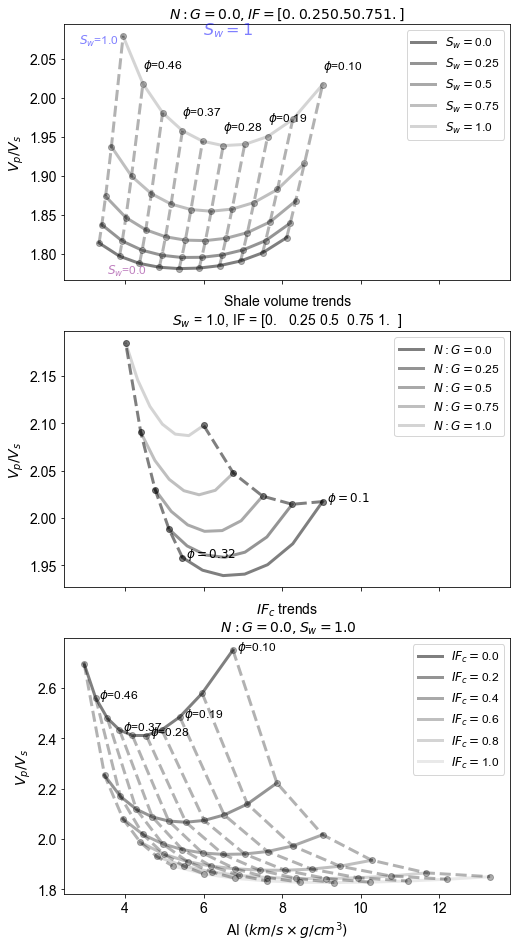

In [51]:
N = 10

por = np.linspace(0.1,0.5,N)
vsh = np.linspace(0,1,N/2)
sw = np.linspace(0,1,N/2)
IF = np.linspace(0,1,N/2)
RPT = IF_RPT(Mspec,por,vsh,sw)
plot_RPTs(RPT,Mspec,por,vsh,sw,IF,bo2_resSec)

## Function: Plot RPT and data

In [52]:
def plot_RPT_data(RPT,Mspec,Por,vsh,S_w,IF,data):

    from mpl_toolkits.axes_grid1.inset_locator import inset_axes
    
    from random import randint
    col = []

    for i in range(10):
        col.append('#%06X' % randint(0, 0xFFFFFF))

    # RPT plot with data
    fig = plt.figure(figsize=(8,6))
    ax= fig.add_axes([0.1,0.1,0.8,0.8])

    IFidx = np.argmin(np.abs(IF - Mspec['IFc']))
    
    # Plot RPTs as function of various fluids
    for m in range(len(RPT['AI'][0,0,:,IFidx])):
        ax.plot(RPT['AI'][:,0,m,IFidx],RPT['PS'][:,0,m,IFidx],'-',alpha=0.5,ms=6,lw=3,label='$S_w=$'+str(S_w[m]),color=str(m/6),)
    for n in range(len(RPT['AI'][:,0,0,IFidx])):
        ax.plot(RPT['AI'][n,0,:,IFidx],RPT['PS'][n,0,:,IFidx],'--ok',alpha=0.3,ms=6,lw=3)
    ax.axis('tight')  
    ax.set_ylabel(r'$V_p/V_s$', fontsize = 14)
    for i,val in enumerate(Por[::2]):
        ax.text(RPT['AI'][i*2,0,-1,IFidx],RPT['PS'][i*2,0,-1,IFidx]+.02,
                   '$\phi$={:.02f}'.format(np.round(val,2)), ha='center', backgroundcolor='none',fontsize=12)

    ax.text(RPT['AI'][-1,0,-1,IFidx]-0.1,RPT['PS'][-1,0,-1,IFidx]-0.01,
               '$S_w$={:.01f}'.format(S_w[-1]),ha='right', backgroundcolor='none',fontsize=12,color = 'blue',alpha=0.5)
    ax.text(RPT['AI'][-1,0,0,IFidx]+0.2,RPT['PS'][-1,0,0,IFidx]-0.04,
               '$S_w$={:.01f}'.format(S_w[0]),ha='left', backgroundcolor='none',fontsize=12,color = 'purple',alpha=0.5)
    ax.title.set_text('$N:G={0}, IF={1}$'.format(vsh[0], IF))
    ax.title.set_fontsize(14)


    # Add data
    reservoir = data[(data['F_label']!='Sola') & (data['F_label']!='Valhall')]
    nonreservoir = data[(data['F_label']=='Sola')]
    if Mspec['fluidS'] == 'water':

        
        lc = ax.scatter(reservoir['AI_w'],reservoir['PS_w'],c=reservoir['VSH'],s=120,edgecolors='0.9',alpha=0.5,marker='s',label='Tuxen (water)')
        sc = ax.scatter(reservoir['AI'],reservoir['PS'],c=reservoir['SW'],s=120,edgecolors='0.9',alpha=0.5,cmap='cividis_r',label='Tuxen')
        sc2 = ax.scatter(nonreservoir['AI'],nonreservoir['PS'],marker='x',color='k',label='Sola')
        
        # Lithology bar setup
        axins = inset_axes(ax,
                        width="3%",  # width = 50% of parent_bbox width
                        height="30%",  # height : 5%
                        loc='lower right')
        cbar = fig.colorbar(lc, cax = axins, ax=ax)
        cbar.ax.tick_params(labelsize=12)
        #cbar.ax.set_yticklabels('')
        cbar.set_label('$Shale vol.$',fontsize=12)
        
    if Mspec['fluidS'] == 'dry':
        sc = ax.scatter(reservoir['AI_d'],reservoir['PS_d'],c=reservoir['SW'],s=120,edgecolors='0.9',alpha=0.5,cmap='cividis_r',label='Tuxen')
        sc2 = ax.scatter(nonreservoir['AI'],nonreservoir['PS'],marker='x',color='k',label='Sola')
        
    if Mspec['fluidS'] == 'insitu':
        sc = ax.scatter(reservoir['AI'],reservoir['PS'],c=reservoir['SW'],s=120,edgecolors='0.9',alpha=0.5,cmap='cividis_r',label='Tuxen')
        sc2 = ax.scatter(nonreservoir['AI'],nonreservoir['PS'],marker='x',color='k',label='Sola')
        
    ax.set_ylim(1.6,2.2)
    ax.set_xlabel('AI '+ r'$(km/s \times g/cm^3)$', fontsize = 14)


    # Colour bar setup
    axins = inset_axes(ax,
                        width="3%",  # width = 50% of parent_bbox width
                        height="30%",  # height : 5%
                        loc='upper left')
    cbar = fig.colorbar(sc, cax = axins, ax=ax)
    cbar.ax.tick_params(labelsize=12)
    #cbar.ax.set_yticklabels('')
    cbar.set_label('$S_w$',fontsize=14)

    ax.legend(loc=1,fontsize=12)

    #plt.savefig('RPT_BO2.png',dpi = 300)

    plt.show()
   

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning:

object of type <class 'float'> cannot be safely interpreted as an integer.

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: DeprecationWarning:

object of type <class 'float'> cannot be safely interpreted as an integer.



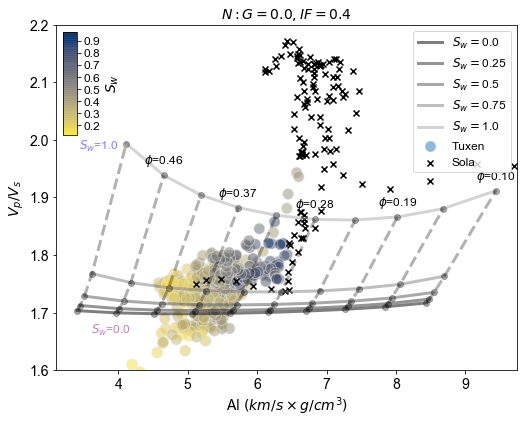

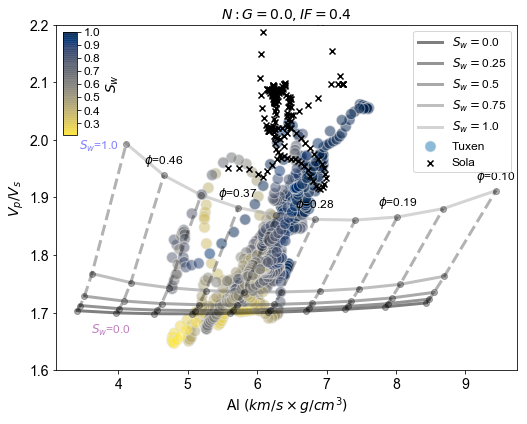

In [53]:
Mspec = {
    'chalk':[2.71,71,30],'quartz':[2.65,37.3,44.8],'shale':[2.7,15,7], # Solid properties
    'water':[1.03,2.3],'oil':[0.8,0.2], # Fluid properties
    'Vch_L':0.1,'Vqz_L':0.1,'Vsh_L':0.05, # Volume fraction of FRAME ("Large") components
    'Vch_s':0.6,'Vqz_s':0.05,'Vsh_s':0.1, # Volume fraction of FRAME ("Large") components
    'PorC':0.66, # Critical porosity 
    'IFc':np.linspace(0,1,6),'IFq':0.2,'IFs':0.2, # IF-values for chalk, quartz and shale
    'fluidS':'insitu' # insitu, dry or water
}

N = 10

por = np.linspace(0.1,0.5,N)
vsh = np.linspace(0,1,N/2)
sw = np.linspace(0,1,N/2)
IF = 0.4
RPT = IF_RPT(Mspec,por,vsh,sw)
plot_RPT_data(RPT,Mspec,por,vsh,sw,IF,bo2_resSec)
plot_RPT_data(RPT,Mspec,por,vsh,sw,IF,jude1_resSec)


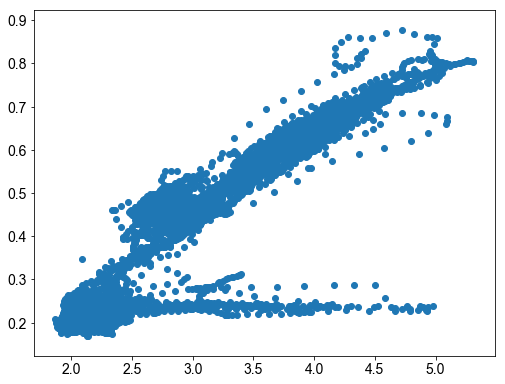

In [54]:
fig = plt.figure(figsize=(8,6))
ax= fig.add_axes([0.1,0.1,0.8,0.8])

ax.scatter((1e3 / bo3['DT']),(1e3 / bo3['DTS']))

## Study lithology trends in the data

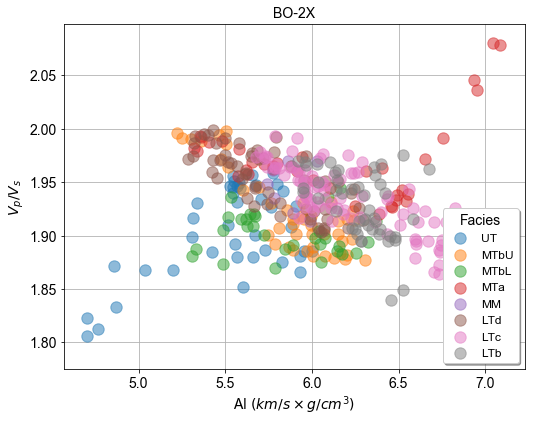

In [55]:
fig = plt.figure(figsize=(8,6))
ax= fig.add_axes([0.1,0.1,0.8,0.8])

groups = bo2_resSec['F_label'].unique()

for i in range(len(groups)):
    x, y = (bo2_resSec[bo2_resSec['F_label']==groups[i]]['AI'],bo2_resSec[bo2_resSec['F_label']==groups[i]]['PS'])
    u, v = (bo2_resSec[bo2_resSec['F_label']==groups[i]]['AI_w'],bo2_resSec[bo2_resSec['F_label']==groups[i]]['PS_w'])
    if (groups[i]!='Sola' and groups[i]!='Valhall'):
        #ax.scatter(x, y, alpha=0.5, s=130, label=groups[i])
        ax.scatter(u, v, alpha=0.5, s=130, label=groups[i],marker='o')
        #ax.scatter(u, v, alpha=0.5, s=130, c = bo2_resSec[bo2_resSec['F_label']==groups[i]]['VSH'])


ax.set_xlabel('AI '+ r'$(km/s \times g/cm^3)$', fontsize = 14)
ax.set_ylabel(r'$V_p/V_s$', fontsize = 14)
ax.set_title('BO-2X',fontsize=14)
#ax.set_xlim(3.5,8)
ax.grid()
ax.set_axisbelow(True)
lg = ax.legend(loc=4,title='Facies',fontsize=12,fancybox=True,shadow=True)
plt.setp(lg.get_title(),fontsize=14)

plt.show()

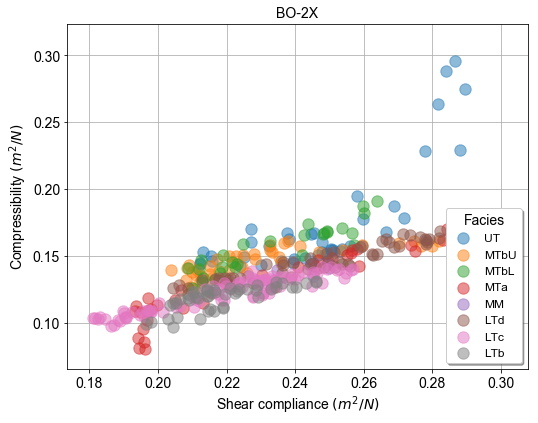

In [56]:
fig = plt.figure(figsize=(8,6))
ax= fig.add_axes([0.1,0.1,0.8,0.8])

groups = bo2_resSec['F_label'].unique()

for i in range(len(groups)):
    u, v = (1/bo2_resSec[bo2_resSec['F_label']==groups[i]]['G'],1/bo2_resSec[bo2_resSec['F_label']==groups[i]]['K'])
    if (groups[i]!='Sola' and groups[i]!='Valhall'):
        ax.scatter(u, v, alpha=0.5, s=130, label=groups[i],marker='o')


ax.set_xlabel(r'Shear compliance $(m^2/N)$', fontsize = 14)
ax.set_ylabel(r'Compressibility $(m^2/N)$', fontsize = 14)
ax.set_title('BO-2X',fontsize=14)
#ax.set_xlim(3.5,8)
ax.grid()
ax.set_axisbelow(True)
lg = ax.legend(loc=4,title='Facies',fontsize=12,fancybox=True,shadow=True)
plt.setp(lg.get_title(),fontsize=14)

plt.show()

## IF-modeling BO2 using serveral IF factors

In [57]:
# Physical properties of constituents
K_o=0.62     # oil
Rho_o=0.8

K_w=2.3
G_w=0         # water
Rho_w=1.03

K_ca=71  
G_ca=30       # calcite
Rho_ca=2.71

K_q=37.3  
G_q=44.8      # quartz
Rho_q=2.65

K_k=15  
G_k=7       # shale
Rho_k=2.7


# Volume fraction of large calcite and large silicates 
Vc_l = 0.1 # large calcite
Vq_l = 0 # large quartz
Vk_l = 0.05 # large kaolinite

# Volume fraction of small calcite and suspended silicates
Vc_s = 0.7 # small calcite
Vq_s = 0.1 # small quartz
Vk_s = 0.05 # small kaolinite

Vtot_sh = Vk_s + Vk_l
Vtot_r = Vc_l+Vq_l+Vc_s+Vq_s

c_l = np.zeros(len(bo2_resSec['PHI'])) 
c_l[:] = np.nan
c_s = np.zeros(len(bo2_resSec['PHI']))
c_s[:] = np.nan
c_l = np.zeros(len(bo2_resSec['PHI']))
c_l[:] = np.nan
q_l = np.zeros(len(bo2_resSec['PHI']))
q_l[:] = np.nan
q_s = np.zeros(len(bo2_resSec['PHI']))
q_s[:] = np.nan
k_s = np.zeros(len(bo2_resSec['PHI']))
k_s[:] = np.nan
k_l = np.zeros(len(bo2_resSec['PHI']))
k_l[:] = np.nan

Por = np.zeros(len(bo2_resSec['PHI']))
Por[:] = np.nan
S_w = np.zeros(len(bo2_resSec['PHI']))
S_w[:] = np.nan

# Dynamic reservoir properties from log data
for n in range(len(bo2_resSec['PHI'])):
    
    # Normalizing the solid volume fractions according to the shale log
    c_l[n] = (1-bo2_resSec['VSH'].iloc[n]) * Vc_l/Vtot_r
    c_s[n] = (1-bo2_resSec['VSH'].iloc[n]) * Vc_s/Vtot_r
    q_l[n] = (1-bo2_resSec['VSH'].iloc[n]) * Vq_l/Vtot_r
    q_s[n] = (1-bo2_resSec['VSH'].iloc[n]) * Vq_s/Vtot_r
    k_s[n] = bo2_resSec['VSH'].iloc[n] * Vk_s/Vtot_sh
    k_l[n] = bo2_resSec['VSH'].iloc[n] * Vk_l/Vtot_sh
    
    Por[n] = bo2_resSec['PHI'].iloc[n]
    S_w[n] = bo2_resSec['SW'].iloc[n]

# Reservoir properties
Por_c = 0.66 # Critical porosity
fluidMix = 'reuss'

In [58]:
# Modeling

IFc = np.linspace(0,1,6) # Iso-frame value for the suspended chalk
IFs = 0.2 # Iso-frame value for the suspended shale
IFq = 0.2 # Iso-frame value for the suspended quartz

K_sus = np.nan*np.ones((Por.size,IFc.size))
K_IF = np.nan*np.ones((Por.size,IFc.size))
G_IF = np.nan*np.ones((Por.size,IFc.size))
M_IF = np.nan*np.ones((Por.size,IFc.size))
Vp_IF = np.nan*np.ones((Por.size,IFc.size))
Vs_IF = np.nan*np.ones((Por.size,IFc.size))
AI_IF = np.nan*np.ones((Por.size,IFc.size))
PS_IF = np.nan*np.ones((Por.size,IFc.size))
Rho = np.nan*np.ones((Por.size,IFc.size))

K_f = S_w/K_w + (1-S_w)/K_o
Rho =  Por*((Rho_w*S_w) + (Rho_o*(1-S_w))) + ((1-Por)*((c_s+c_l)*Rho_ca + Rho_k*(k_s+k_l) + Rho_q*(q_s+q_l)))

for n in range(len(IFc)):

    K_sus[:,n] = ( Por/Por_c*K_f + (1-Por/Por_c)*( (c_s*(1-IFc[n])/K_ca) + (q_s*(1-IFq)/K_q) + (k_s*(1-IFs)/K_k) ) )**(-1) * (Por/Por_c + (1-Por/Por_c)*( c_s*(1-IFc[n]) + q_s*(1-IFq) + k_s*(1-IFs)) )

    K_IF[:,n] = ( ((Por/Por_c)/(K_sus[:,n] + (4/3)*G_ca)) + (1-(Por/Por_c))* ( (((1-IFc[n])*c_s + (1-IFq)*q_s + (1-IFs)*k_s)/(K_sus[:,n] + (4/3)*G_ca)) + ((IFc[n]*c_s+c_l) / (K_ca + (4/3)*G_ca)) + ( (IFq*q_s+q_l) / (K_q + (4/3)*G_ca)) + ((IFs*k_s+k_l) / (K_k + (4/3)*G_ca)) ))**(-1) - (4/3)*G_ca

    zeta = (G_ca/6) * ((9*K_ca + 8*G_ca)/(K_ca + 2*G_ca));

    G_IF[:,n] = ( ((Por/Por_c)/zeta) +  (1-(Por/Por_c))*( (((1-IFc[n])*c_s + (1-IFq)*q_s + (1-IFs)*k_s)/(zeta)) + ((IFc[n]*c_s+c_l)/(G_ca + zeta)) + ((IFq*q_s+q_l)/(G_q + zeta)) + ( (IFs*k_s+k_l) / (G_k + zeta))) )**(-1) - zeta

    M_IF[:,n] = K_IF[:,n] + (4/3)*G_IF[:,n]

    Vp_IF[:,n] = np.sqrt((K_IF[:,n] + (4/3)*G_IF[:,n]) / Rho)
    Vs_IF[:,n] = np.sqrt(G_IF[:,n] / Rho)

    AI_IF[:,n] = Vp_IF[:,n] * Rho
    PS_IF[:,n] = Vp_IF[:,n] / Vs_IF[:,n]


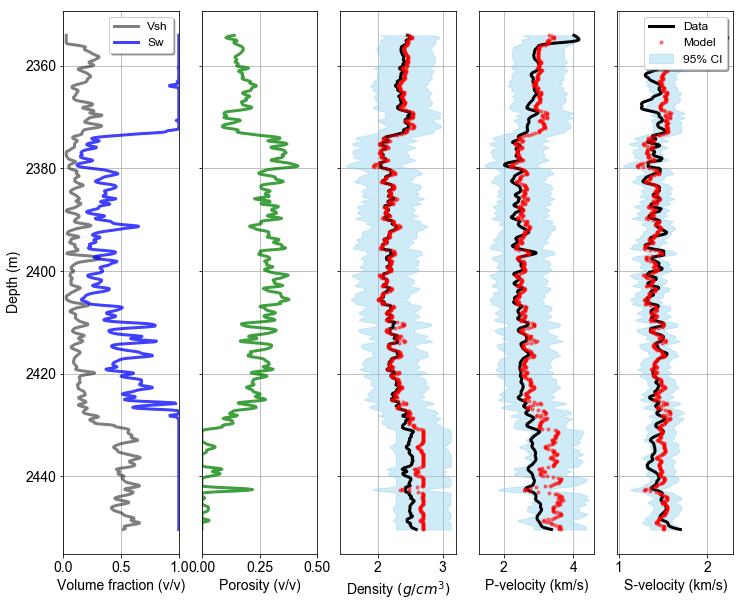

In [59]:
fig, axes = plt.subplots(nrows=1, ncols=5,figsize=(12,10))

axes[0].plot(bo2_resSec['VSH'],bo2_resSec.index,'k',alpha=0.5,label='Vsh',lw=3)
axes[0].plot(bo2_resSec['SW'],bo2_resSec.index, 'b',alpha=0.75,label='Sw',lw=3)
axes[0].invert_yaxis()
axes[0].set_ylabel('Depth (m)', fontsize = 14)
axes[0].set_xlabel('Volume fraction (v/v)', fontsize = 14)
axes[0].axis('tight')
axes[0].grid()
axes[0].set_axisbelow(True)
axes[0].set_xlim(0,1)
axes[0].legend(loc=1,fontsize=12,fancybox=True,shadow=True)

axes[1].plot(bo2_resSec['PHI'],bo2_resSec.index,'g',alpha=0.75,lw=3)
axes[1].invert_yaxis()
axes[1].set_yticklabels('')
axes[1].set_xlabel('Porosity (v/v)', fontsize = 14)
axes[1].axis('tight')
axes[1].grid()
axes[1].set_axisbelow(True)
axes[1].set_xlim(0,0.5)

axes[2].plot(bo2_resSec['rho_edt'],bo2_resSec.index,'k',alpha=1,lw=3)
axes[2].plot(Rho,bo2_resSec.index,'r.',alpha=0.5)
yerr = Rho.std() * 2 # ~ 95% confidence interval
axes[2].fill_betweenx(bo2_resSec.index,Rho-yerr,Rho+yerr,color='skyblue',alpha=0.4)
axes[2].invert_yaxis()
axes[2].set_yticklabels('')
axes[2].set_xlabel('Density '+ r'$(g/cm^3)$', fontsize = 14)
axes[2].axis('tight')
axes[2].grid()
axes[2].set_axisbelow(True)

axes[3].plot(bo2_resSec['Vp'],bo2_resSec.index,'k',alpha=1,lw=3)
axes[4].plot(bo2_resSec['Vs'],bo2_resSec.index,'k',alpha=1,lw=3,label='Data')

axes[3].plot(Vp_IF[:,2],bo2_resSec.index,'r.',alpha=0.5)
yerr = Vp_IF[:,2].std() * 2 # ~ 95% confidence interval
axes[3].fill_betweenx(bo2_resSec.index,Vp_IF[:,2]-yerr,Vp_IF[:,2]+yerr,color='skyblue',alpha=0.4)

axes[4].plot(Vs_IF[:,2],bo2_resSec.index,'r.',alpha=0.5,label='Model')
yerr = Vs_IF[:,2].std() * 2 # ~ 95% confidence interval
axes[4].fill_betweenx(bo2_resSec.index,Vs_IF[:,2]-yerr,Vs_IF[:,2]+yerr,color='skyblue',alpha=0.4,label='95% CI')

        
axes[3].invert_yaxis()
axes[3].set_yticklabels('')
axes[3].set_xlabel('P-velocity (km/s)', fontsize = 14)
axes[3].axis('tight')
axes[3].grid()
axes[3].set_axisbelow(True)


axes[4].invert_yaxis()
axes[4].set_yticklabels('')
axes[4].set_xlabel('S-velocity (km/s)', fontsize = 14)
axes[4].axis('tight')
axes[4].grid()
axes[4].set_axisbelow(True)
axes[4].legend(loc=1,fontsize=12,fancybox=True,shadow=True)

plt.show()

## IF-modeling Jude-1 using serveral IF factors

In [65]:
# Physical properties of constituents
K_o=0.62     # oil
Rho_o=0.8

K_w=2.3
G_w=0         # water
Rho_w=1.03

K_ca=71  
G_ca=30       # calcite
Rho_ca=2.71

K_q=37.3  
G_q=44.8      # quartz
Rho_q=2.65

K_k=15  
G_k=7       # shale
Rho_k=2.7


# Volume fraction of large calcite and large silicates 
Vc_l = 0.1 # large calcite
Vq_l = 0 # large quartz
Vk_l = 0.05 # large kaolinite

# Volume fraction of small calcite and suspended silicates
Vc_s = 0.7 # small calcite
Vq_s = 0.1 # small quartz
Vk_s = 0.05 # small kaolinite

Vtot_sh = Vk_s + Vk_l
Vtot_r = Vc_l+Vq_l+Vc_s+Vq_s

c_l = np.zeros(len(jude1_resSec['PHI'])) 
c_l[:] = np.nan
c_s = np.zeros(len(jude1_resSec['PHI']))
c_s[:] = np.nan
c_l = np.zeros(len(jude1_resSec['PHI']))
c_l[:] = np.nan
q_l = np.zeros(len(jude1_resSec['PHI']))
q_l[:] = np.nan
q_s = np.zeros(len(jude1_resSec['PHI']))
q_s[:] = np.nan
k_s = np.zeros(len(jude1_resSec['PHI']))
k_s[:] = np.nan
k_l = np.zeros(len(jude1_resSec['PHI']))
k_l[:] = np.nan

Por = np.zeros(len(jude1_resSec['PHI']))
Por[:] = np.nan
S_w = np.zeros(len(jude1_resSec['PHI']))
S_w[:] = np.nan

# Dynamic reservoir properties from log data
for n in range(len(jude1_resSec['PHI'])):
    
    # Normalizing the solid volume fractions according to the shale log
    c_l[n] = (1-jude1_resSec['VSH'].iloc[n]) * Vc_l/Vtot_r
    c_s[n] = (1-jude1_resSec['VSH'].iloc[n]) * Vc_s/Vtot_r
    q_l[n] = (1-jude1_resSec['VSH'].iloc[n]) * Vq_l/Vtot_r
    q_s[n] = (1-jude1_resSec['VSH'].iloc[n]) * Vq_s/Vtot_r
    k_s[n] = jude1_resSec['VSH'].iloc[n] * Vk_s/Vtot_sh
    k_l[n] = jude1_resSec['VSH'].iloc[n] * Vk_l/Vtot_sh
    
    Por[n] = jude1_resSec['PHI'].iloc[n]
    S_w[n] = jude1_resSec['SW'].iloc[n]

# Reservoir properties
Por_c = 0.66 # Critical porosity
fluidMix = 'reuss'

In [66]:
# Modeling

IFc = np.linspace(0,1,6) # Iso-frame value for the suspended chalk
IFs = 0.3 # Iso-frame value for the suspended shale
IFq = 0.4 # Iso-frame value for the suspended quartz

K_sus = np.nan*np.ones((Por.size,IFc.size))
K_IF = np.nan*np.ones((Por.size,IFc.size))
G_IF = np.nan*np.ones((Por.size,IFc.size))
M_IF = np.nan*np.ones((Por.size,IFc.size))
Vp_IF = np.nan*np.ones((Por.size,IFc.size))
Vs_IF = np.nan*np.ones((Por.size,IFc.size))
AI_IF = np.nan*np.ones((Por.size,IFc.size))
PS_IF = np.nan*np.ones((Por.size,IFc.size))
Rho = np.nan*np.ones((Por.size,IFc.size))

K_f = S_w/K_w + (1-S_w)/K_o
Rho =  Por*((Rho_w*S_w) + (Rho_o*(1-S_w))) + ((1-Por)*((c_s+c_l)*Rho_ca + Rho_k*(k_s+k_l) + Rho_q*(q_s+q_l)))

for n in range(len(IFc)):

    K_sus[:,n] = ( Por/Por_c*K_f + (1-Por/Por_c)*( (c_s*(1-IFc[n])/K_ca) + (q_s*(1-IFq)/K_q) + (k_s*(1-IFs)/K_k) ) )**(-1) * (Por/Por_c + (1-Por/Por_c)*( c_s*(1-IFc[n]) + q_s*(1-IFq) + k_s*(1-IFs)) )

    K_IF[:,n] = ( ((Por/Por_c)/(K_sus[:,n] + (4/3)*G_ca)) + (1-(Por/Por_c))* ( (((1-IFc[n])*c_s + (1-IFq)*q_s + (1-IFs)*k_s)/(K_sus[:,n] + (4/3)*G_ca)) + ((IFc[n]*c_s+c_l) / (K_ca + (4/3)*G_ca)) + ( (IFq*q_s+q_l) / (K_q + (4/3)*G_ca)) + ((IFs*k_s+k_l) / (K_k + (4/3)*G_ca)) ))**(-1) - (4/3)*G_ca

    zeta = (G_ca/6) * ((9*K_ca + 8*G_ca)/(K_ca + 2*G_ca));

    G_IF[:,n] = ( ((Por/Por_c)/zeta) +  (1-(Por/Por_c))*( (((1-IFc[n])*c_s + (1-IFq)*q_s + (1-IFs)*k_s)/(zeta)) + ((IFc[n]*c_s+c_l)/(G_ca + zeta)) + ((IFq*q_s+q_l)/(G_q + zeta)) + ( (IFs*k_s+k_l) / (G_k + zeta))) )**(-1) - zeta

    M_IF[:,n] = K_IF[:,n] + (4/3)*G_IF[:,n]

    Vp_IF[:,n] = np.sqrt((K_IF[:,n] + (4/3)*G_IF[:,n]) / Rho)
    Vs_IF[:,n] = np.sqrt(G_IF[:,n] / Rho)

    AI_IF[:,n] = Vp_IF[:,n] * Rho
    PS_IF[:,n] = Vp_IF[:,n] / Vs_IF[:,n]


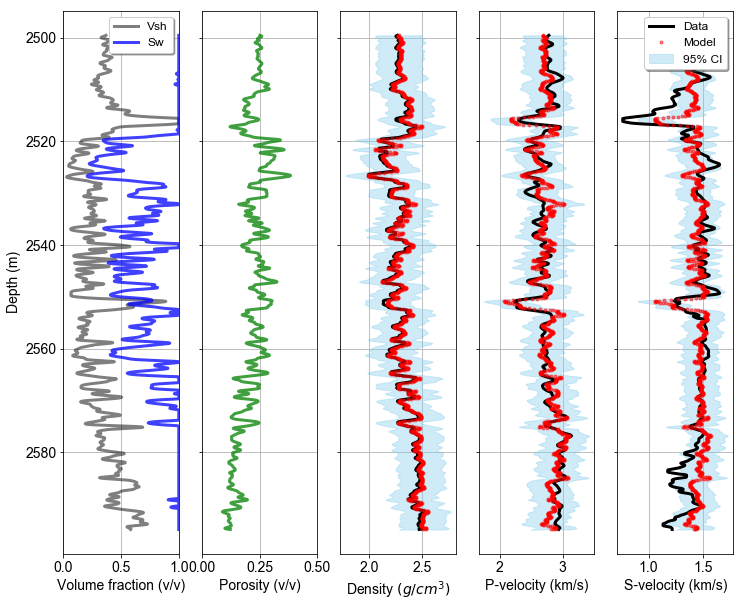

In [68]:
fig, axes = plt.subplots(nrows=1, ncols=5,figsize=(12,10))

axes[0].plot(jude1_resSec['VSH'],jude1_resSec.index,'k',alpha=0.5,label='Vsh',lw=3)
axes[0].plot(jude1_resSec['SW'],jude1_resSec.index, 'b',alpha=0.75,label='Sw',lw=3)
axes[0].invert_yaxis()
axes[0].set_ylabel('Depth (m)', fontsize = 14)
axes[0].set_xlabel('Volume fraction (v/v)', fontsize = 14)
axes[0].axis('tight')
axes[0].grid()
axes[0].set_axisbelow(True)
axes[0].set_xlim(0,1)
axes[0].legend(loc=1,fontsize=12,fancybox=True,shadow=True)

axes[1].plot(jude1_resSec['PHI'],jude1_resSec.index,'g',alpha=0.75,lw=3)
axes[1].invert_yaxis()
axes[1].set_yticklabels('')
axes[1].set_xlabel('Porosity (v/v)', fontsize = 14)
axes[1].axis('tight')
axes[1].grid()
axes[1].set_axisbelow(True)
axes[1].set_xlim(0,0.5)

axes[2].plot(jude1_resSec['rho_edt'],jude1_resSec.index,'k',alpha=1,lw=3)
axes[2].plot(Rho,jude1_resSec.index,'r.',alpha=0.5)
yerr = Rho.std() * 2 # ~ 95% confidence interval
axes[2].fill_betweenx(jude1_resSec.index,Rho-yerr,Rho+yerr,color='skyblue',alpha=0.4)
axes[2].invert_yaxis()
axes[2].set_yticklabels('')
axes[2].set_xlabel('Density '+ r'$(g/cm^3)$', fontsize = 14)
axes[2].axis('tight')
axes[2].grid()
axes[2].set_axisbelow(True)

axes[3].plot(jude1_resSec['Vp'],jude1_resSec.index,'k',alpha=1,lw=3)
axes[4].plot(jude1_resSec['Vs'],jude1_resSec.index,'k',alpha=1,lw=3,label='Data')


axes[3].plot(Vp_IF[:,2],jude1_resSec.index,'r.',alpha=0.5)
yerr = Vp_IF[:,2].std() * 2 # ~ 95% confidence interval
axes[3].fill_betweenx(jude1_resSec.index,Vp_IF[:,2]-yerr,Vp_IF[:,2]+yerr,color='skyblue',alpha=0.4)

axes[4].plot(Vs_IF[:,2],jude1_resSec.index,'r.',alpha=0.5,label='Model')
yerr = Vs_IF[:,2].std() * 2 # ~ 95% confidence interval
axes[4].fill_betweenx(jude1_resSec.index,Vs_IF[:,2]-yerr,Vs_IF[:,2]+yerr,color='skyblue',alpha=0.4,label='95% CI')

        
axes[3].invert_yaxis()
axes[3].set_yticklabels('')
axes[3].set_xlabel('P-velocity (km/s)', fontsize = 14)
axes[3].axis('tight')
axes[3].grid()
axes[3].set_axisbelow(True)


axes[4].invert_yaxis()
axes[4].set_yticklabels('')
axes[4].set_xlabel('S-velocity (km/s)', fontsize = 14)
axes[4].axis('tight')
axes[4].grid()
axes[4].set_axisbelow(True)
axes[4].legend(loc=1,fontsize=12,fancybox=True,shadow=True)

plt.show()